# Imports

In [1]:
import requests
import json
import math
import random

import pandas as pd
import numpy as np
from statsmodels.robust.scale import mad
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima.arima import auto_arima
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()
sns.set_style("white")
# import plotly.graph_objects as go

from IPython.display import display
from tqdm import tqdm

import pickle

## Functions

### Dates

In [149]:
def resample_h(df_in, h):
    r = f'{str(h)}h'
    s = int(96/4/int(h))
    return df_in.resample(r).mean(), s, r

def resample_m(df_in, m):
    r = f'{str(60*m)}min'
    s = int(96/4/m)
    return df_in.resample(r).mean(), s, r

def smooth_ma(df_in, p):
    return df_in.rolling(window=p).mean().bfill()

def cutdate(df_in, start_date, amount):
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = start_date_dt + timedelta(days=amount)
    if amount < 0:
        start_date = end_date_dt.strftime('%Y-%m-%d')
        end_date = start_date_dt.strftime('%Y-%m-%d')
    else:
        start_date = start_date_dt.strftime('%Y-%m-%d')
        end_date = end_date_dt.strftime('%Y-%m-%d')
    df_new = df_in[start_date:end_date]
    print(f"{df_new.iloc[0].name.strftime('%Y-%m-%d %H:%M')} - {df_new.iloc[-1].name.strftime('%Y-%m-%d %H:%M')}")
    return df_new

### Stats

In [150]:
def file_stats(df):
    df_first_date = df.iloc[0].datetime
    df_last_date = df.iloc[-1].datetime
    print(f'First date\t{df_first_date}')
    print(f'Last date\t{df_last_date}')
    df_first_date_dt = datetime.strptime(df_first_date,'%Y-%m-%d %H:%M:%S')
    df_last_date_dt = datetime.strptime(df_last_date,'%Y-%m-%d %H:%M:%S')
    print(f'Expected dates\t{df_last_date_dt - df_first_date_dt + timedelta(minutes=15)}')
    print(f'Total dates\t{len(df)/96/14}')

def pred_vs_actual_stats(df_in_pred, df_in_f):
    df_in = pd.concat([df_in_f, df_in_pred], axis=1)
    df_in = df_in.bfill().ffill()
    df_in = df_in.drop(['forecast_week'], axis=1)
    df_in = df_in.rename(columns={0:'prediction'})
    df_in['error'] = df_in.measured - df_in.prediction
    print(f'Mean\t\t{round(df_in.prediction.mean(),2)}')
    print(f'Median\t\t{round(df_in.prediction.median(),2)}')
    print(f'Mode\t\t{round(df_in.prediction.mode()[0],2)}')
    print(f'Std Dev\t\t{round(df_in.prediction.std(),2)}')
    print(f'Mean Error\t{round(df_in.error.mean(),2)}')
    print(f'Median Error\t{round(df_in.error.median(),2)}')
    print(f'Mode Error\t{round(df_in.error.mode()[0],2)}')
    print(f'Error Std Dev\t{round(df_in.error.std(),2)}')
    print(f'Max Error\t{round(abs(df_in.error).max(),2)}')
    print(f'MAE\t\t{round(mean_absolute_error(df_in.measured, df_in.prediction),2)}')
    print(f'MSE\t\t{round(mean_squared_error(df_in.measured, df_in.prediction),2)}')
    print(f'RMSE\t\t{round(np.sqrt(mean_squared_error(df_in.measured, df_in.prediction)),2)}')
    mape = np.where(df_in.measured != 0, np.abs(df_in.error / df_in.measured) * 100, 0)
    print(f'MA%E\t\t{round(np.mean(mape), 2)}')
    print(f'R²\t\t{round(r2_score(df_in.measured, df_in.prediction),2)}')

# Data preprocessing

## Importing the data

### From a file

In [163]:
# raw_data = pd.read_csv('ods032.csv', delimiter=';')
raw_data = pd.read_csv('ods032-api.csv')

In [164]:
df = raw_data.copy()
file_stats(df)

First date	2018-10-01 00:00:00
Last date	2024-10-27 23:45:00
Expected dates	2219 days, 0:00:00
Total dates	2219.0


### From the API

#### Full run

In [6]:
# df = pd.DataFrame()
# start_date = datetime(2018, 10, 1) # first day of data
# end_date = datetime(2018, 10, 1) # yesterday, to avoid partial days
# date_list = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
# regions = ['Wallonia', 'West-Flanders', 'Flanders', 'Antwerp', 'Belgium', 'Walloon-Brabant', 'Brussels', 'Limburg', 'Liège', 'Luxembourg', 'Namur', 'East-Flanders', 'Flemish-Brabant', 'Hainaut']
# max_iterations = len(date_list) * len(regions)

# with tqdm(total=max_iterations, desc='Fetching data') as pbar:
#     for region in regions:
#         for date in date_list:
#             url = f"https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods032/records?select=datetime%2C%20region%2C%20measured%2C%20mostrecentforecast%2C%20dayaheadforecast%2C%20weekaheadforecast&limit=100&refine=region%3A%22{region}%22&refine=datetime%3A%22{date.year}%2F{date.month:02d}%2F{date.day:02d}%22"
#             r = requests.get(url)
#             if r.status_code == 200:
#                 temp_df = pd.DataFrame(r.json()['results'])
#                 df = pd.concat([df, temp_df], ignore_index=True)
#             pbar.update(1)

# df.datetime = pd.to_datetime(df.datetime, utc=True)
# df.datetime = df.datetime.dt.tz_localize(None)
# df.set_index("datetime").sort_index().reset_index().to_csv('ods032-api.csv', index=False)

#### Update

In [ ]:
# api_data = pd.read_csv('ods032-api.csv')
# file_stats(apidata)
# api_data_backup = api_data.copy()

In [ ]:
# # set start date to first day after current dataset

# new_start_date = datetime.strptime(api_data.iloc[-1].datetime,'%Y-%m-%d %H:%M:%S') + timedelta(days=1)
# new_start_year = new_start_date.year
# new_start_month = new_start_date.month
# new_start_day = new_start_date.day

# # set number of days to get

# # new_days = 364
# # new_end_date = new_start_date + timedelta(days=new_days-2)
# # new_end_year = new_end_date.year
# # new_end_month = new_end_date.month
# # new_end_day = new_end_date.day

# # or set fixed end dat

# new_end_year = 2024
# new_end_month = 10
# new_end_day = 28

# df_new = pd.DataFrame()

# start_date = datetime(new_start_year, new_start_month, new_start_day)
# end_date = datetime(new_end_year, new_end_month, new_end_day) # inclusive
# date_list = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
# regions = ['Wallonia', 'West-Flanders', 'Flanders', 'Antwerp', 'Belgium', 'Walloon-Brabant', 'Brussels', 'Limburg', 'Liège', 'Luxembourg', 'Namur', 'East-Flanders', 'Flemish-Brabant', 'Hainaut']
# max_iterations = len(date_list) * len(regions)

# print(f'Days: {len(date_list)}, from {date_list[0]} to {date_list[-1]}')

# with tqdm(total=max_iterations, desc='Fetching data') as pbar:
#     for region in regions:
#         for date in date_list:
#             url = f"https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods032/records?select=datetime%2C%20region%2C%20measured%2C%20mostrecentforecast%2C%20dayaheadforecast%2C%20weekaheadforecast&limit=100&refine=region%3A%22{region}%22&refine=datetime%3A%22{date.year}%2F{date.month:02d}%2F{date.day:02d}%22"
#             r = requests.get(url)
#             if r.status_code == 200:
#                 temp_df = pd.DataFrame(r.json()['results'])
#                 df_new = pd.concat([df_new, temp_df], ignore_index=True)
#             pbar.update(1)

# df_new.datetime = pd.to_datetime(df_new.datetime, utc=True)
# df_new.datetime = df_new.datetime.dt.tz_localize(None)
# df_new = df_new.set_index("datetime").sort_index().reset_index()
# df_new.to_csv('ods032-api.csv', mode='a', header=False, index=False)
# df = pd.concat([api_data, df_new], ignore_index=True)
# df

## Processing

In [13]:
df.duplicated().sum()
# df.drop_duplicates()

0

In [165]:
df = df.rename(columns={'Datetime':'datetime',
                        'Region':'region',
                        'Measured & Upscaled':'measured',
                        'Most recent forecast':'forecast_recent',
                        'Week-ahead forecast':'forecast_week',
                        'Day-ahead 6PM forecast':'forecast_day',
                        'mostrecentforecast':'forecast_recent',
                        'dayaheadforecast':'forecast_day',
                        'weekaheadforecast':'forecast_week'})
df.datetime = pd.to_datetime(df.datetime, utc=True)
df.set_index("datetime", inplace=True)
df = df.sort_index()
df = df.ffill().bfill()

df_be = df[df.region == 'Belgium'].drop(['region'], axis=1).copy()
df_be_fullyears = df_be['2019-01-01':'2023-12-31'].copy()

# Data exploration 

## Describe

In [171]:
pd.options.display.float_format = '{:,.2f}'.format
display(df.describe())
pd.options.display.float_format = None

measured  forecast_recent  forecast_day  forecast_week
count 2,982,336.00     2,982,336.00  2,982,336.00   2,982,336.00
mean        137.48           136.36        136.88         129.52
std         430.63           421.82        424.47         393.90
min           0.00             0.00          0.00           0.00
25%           0.00             0.00          0.00           0.00
50%           0.14             0.50          0.51           0.42
75%          75.69            77.13         77.80          78.17
max       7,526.47         7,055.24      7,280.85       6,512.31

## Plots

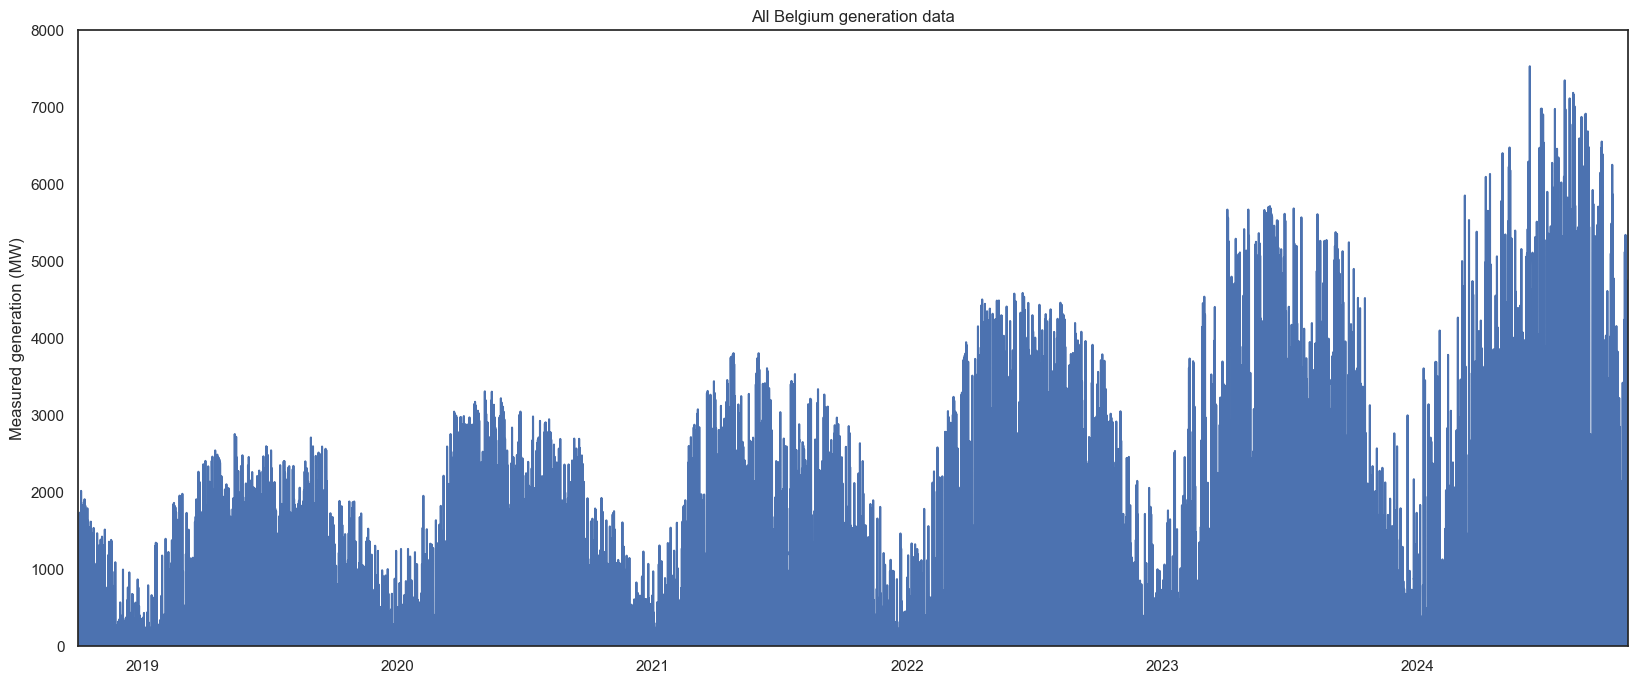

In [157]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be.measured)
plt.ylabel('Measured generation (MW)')
plt.ylim(0,8000)
plt.xlabel('')
plt.xlim(df_be.iloc[0].name,df_be.iloc[-1].name)
plt.title('All Belgium generation data')
plt.show()

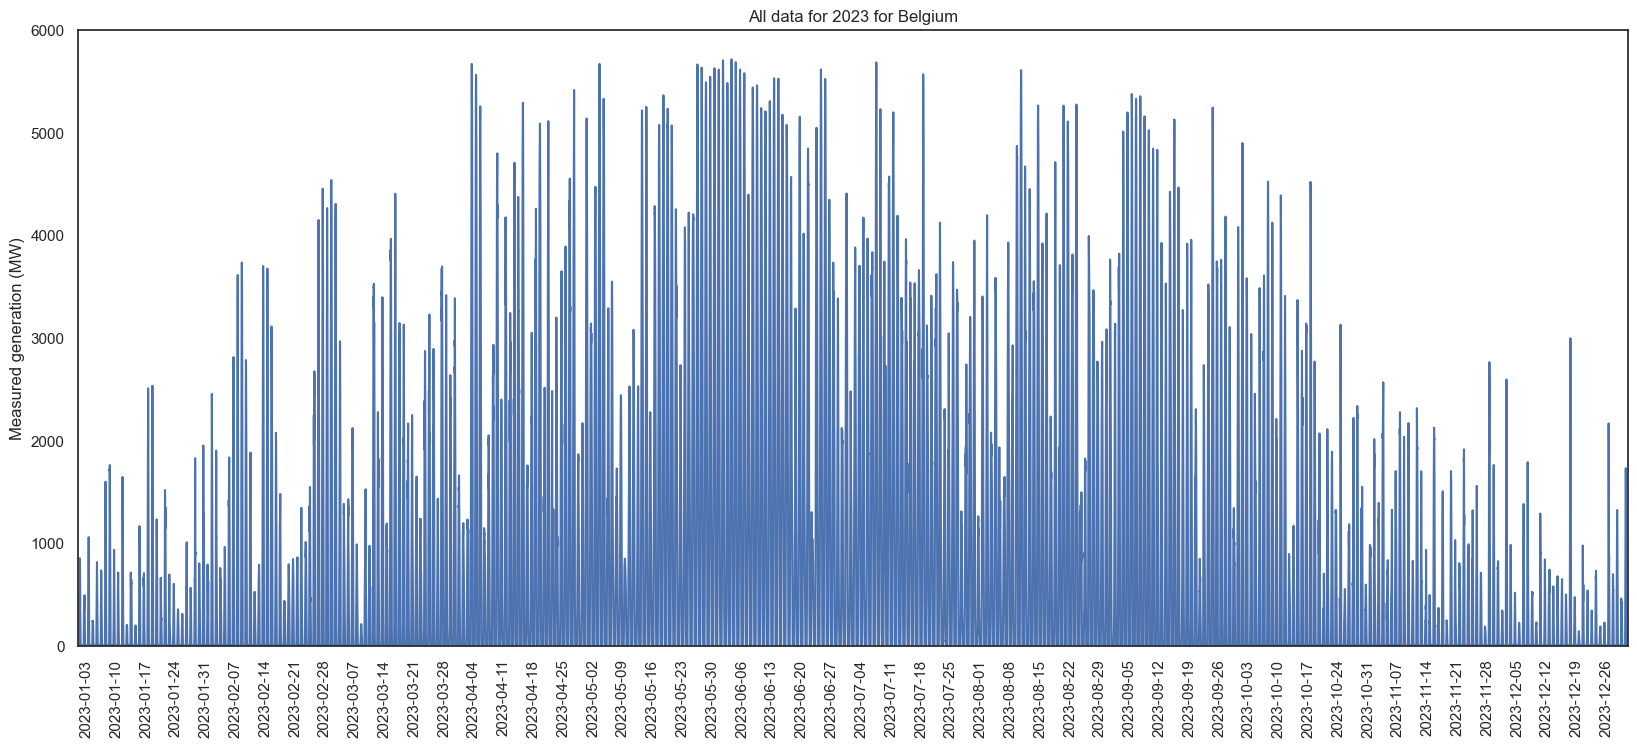

In [159]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be['2023-01-01':'2023-12-31'].measured)
plt.ylabel('Measured generation (MW)')
plt.ylim(0,6000)
plt.xlabel('')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.title('All data for 2023 for Belgium')
plt.show()

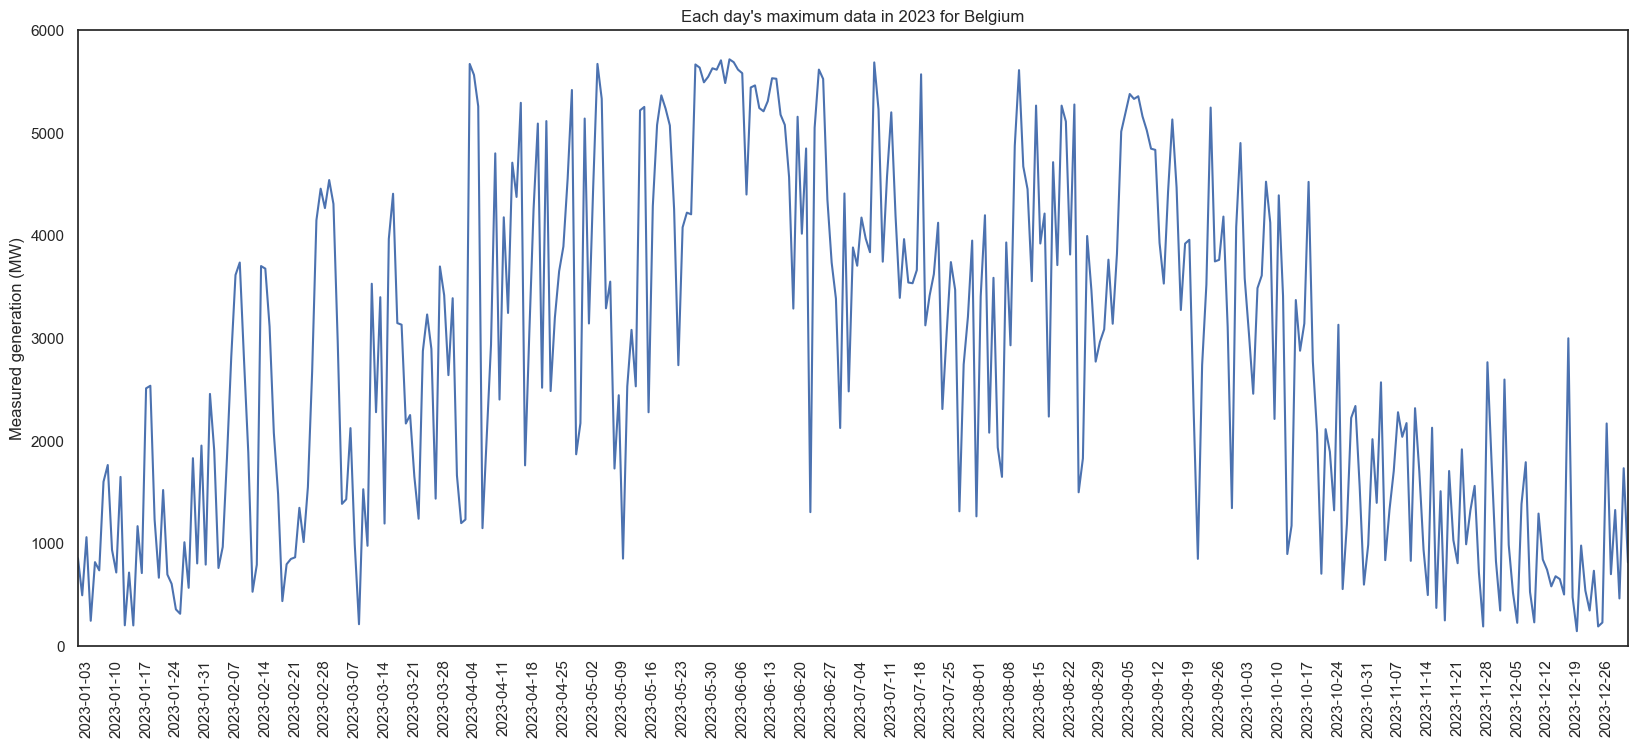

In [160]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be['2023-01-01':'2023-12-31'].measured.resample('D').max())
plt.ylabel('Measured generation (MW)')
plt.ylim(0,6000)
plt.xlabel('')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.title("Each day's maximum data in 2023 for Belgium")
plt.show()

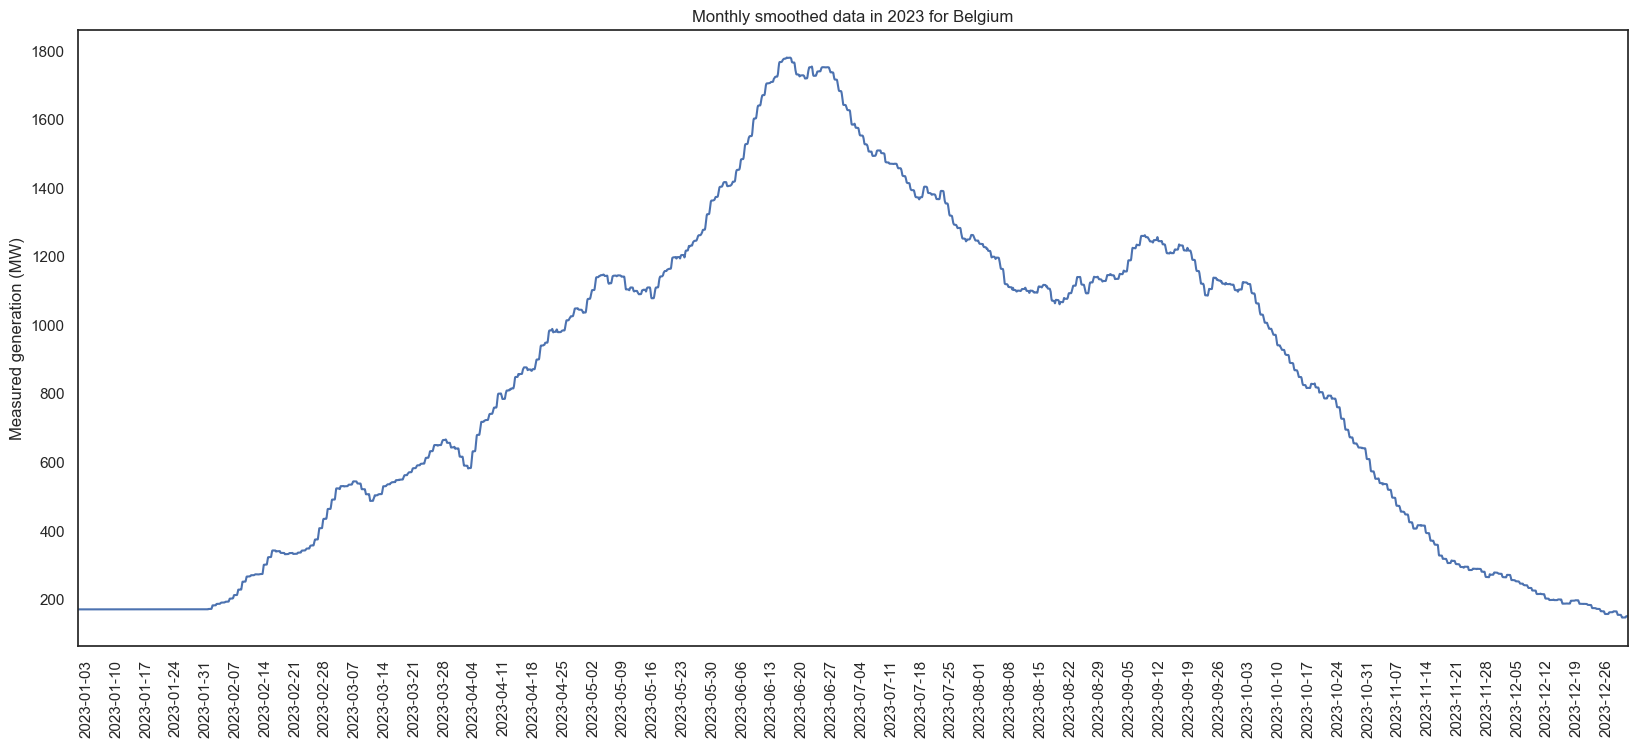

In [161]:
plt.figure(figsize=(20,8))
sns.lineplot(smooth_ma(df_be['2023-01-01':'2023-12-31'].measured,96*30))
plt.ylabel('Measured generation (MW)')
plt.xlabel('')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.title("Monthly smoothed data in 2023 for Belgium")
plt.show()

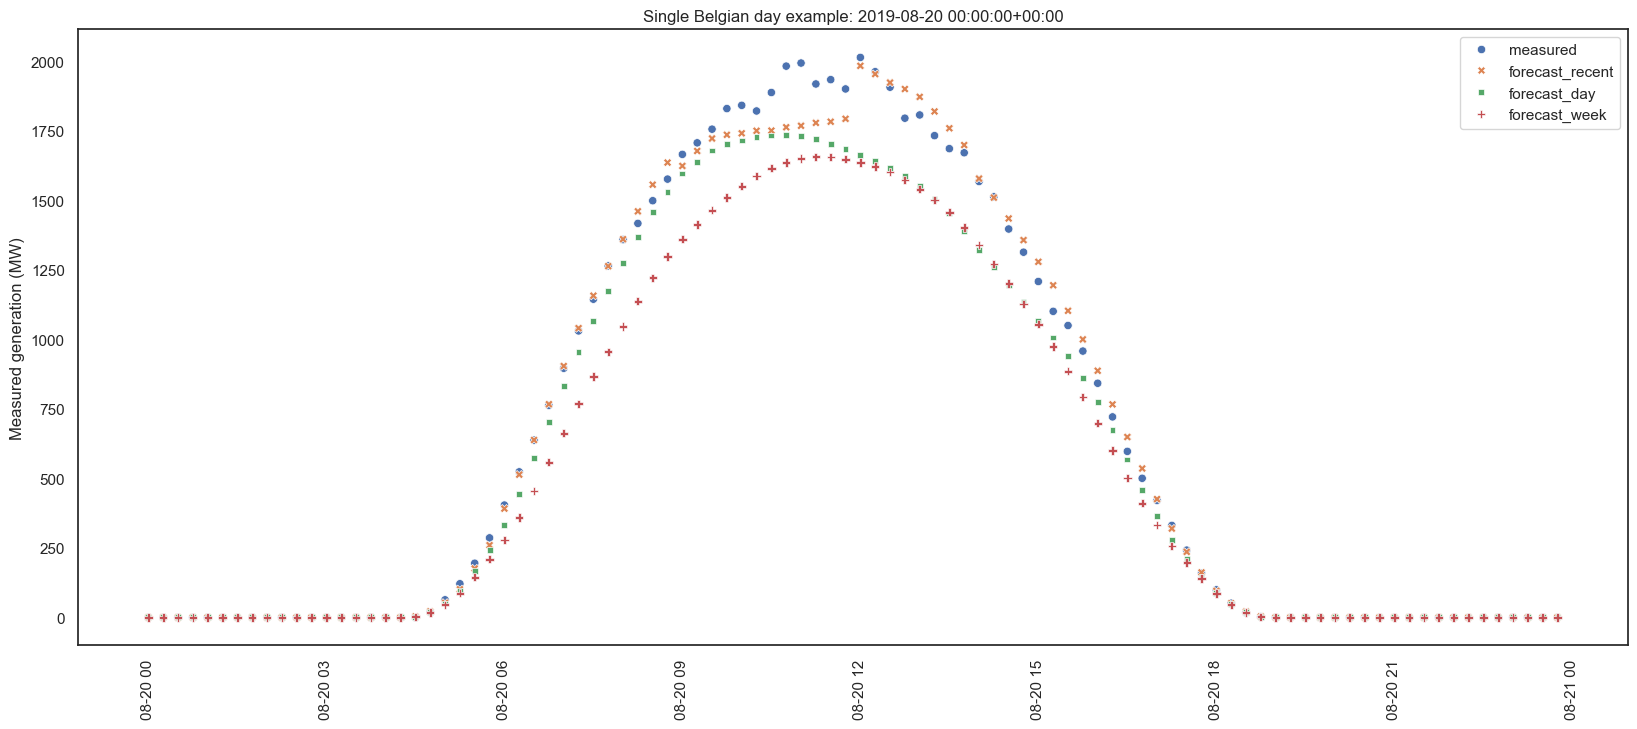

In [ ]:
plt.figure(figsize=(20,8))
random_date = random.choice(df_be.index.normalize().unique())
sns.scatterplot(df_be[['measured','forecast_recent','forecast_day','forecast_week']][df_be.index.normalize() == random_date])
plt.ylabel('Measured generation (MW)')
plt.xlabel('')
plt.xticks(rotation=90)
plt.title(f'Single Belgian day example: {random_date}')
plt.show()

## Grouped by timeframe

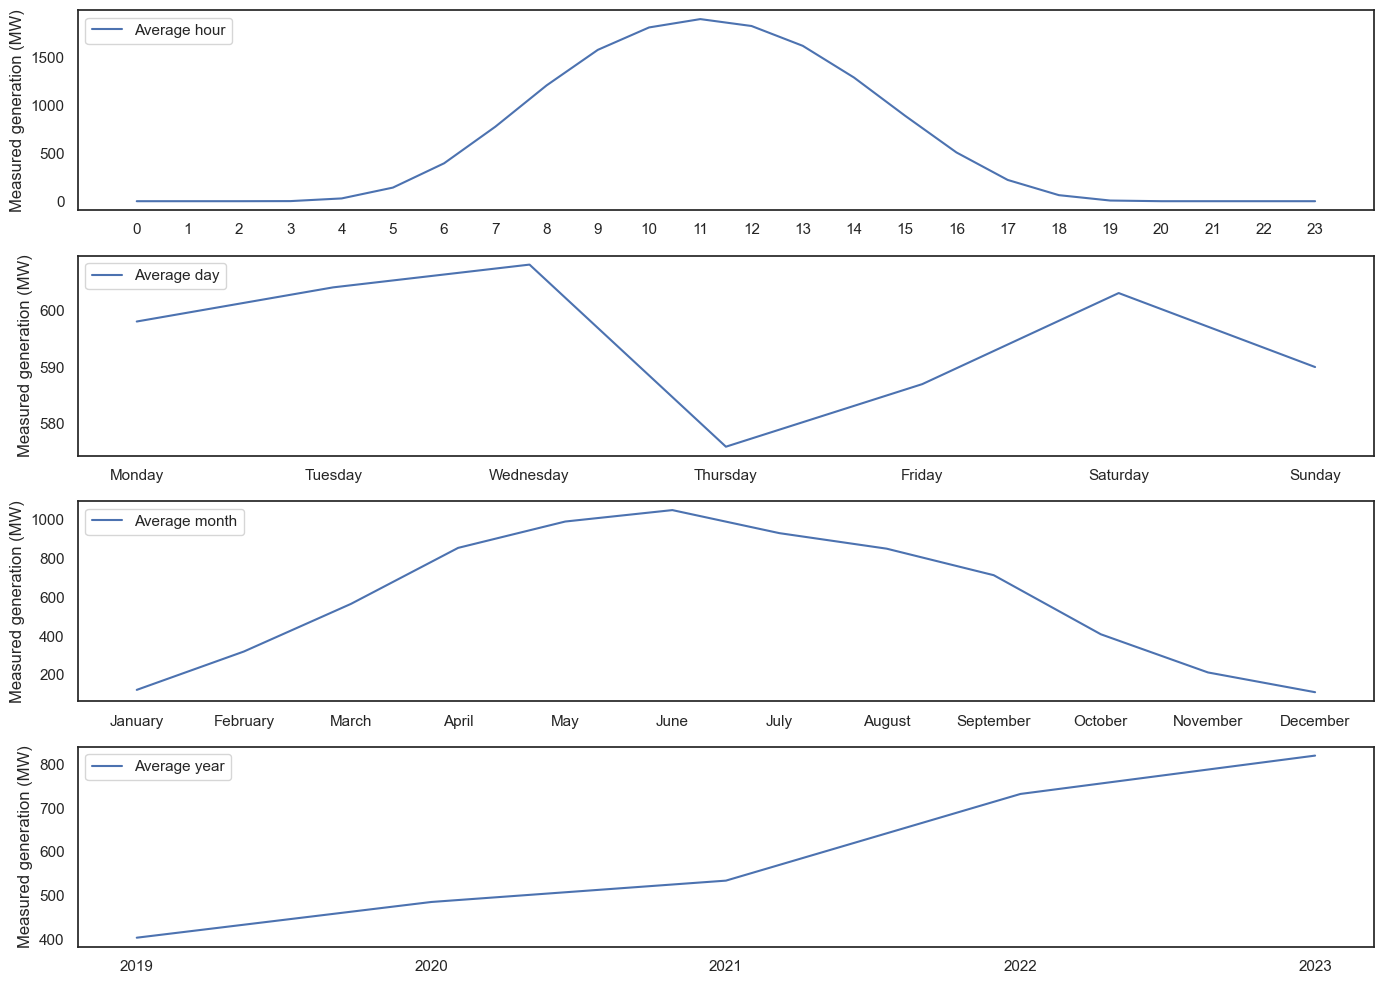

In [168]:
df_timeframe = df_be_fullyears.copy()
df_timeframe['hour'] = df_be_fullyears.index.hour
df_timeframe['day_of_week'] = df_be_fullyears.index.dayofweek
df_timeframe['month'] = df_be_fullyears.index.month
df_timeframe['year'] = df_be_fullyears.index.year

df_timeframe_hour = df_timeframe.groupby('hour').mean()[['measured']].round()
df_timeframe_day_of_week = df_timeframe.groupby('day_of_week').mean()[['measured']].round()
df_timeframe_day_of_week.index = pd.Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_timeframe_month = df_timeframe.groupby('month').mean()[['measured']].round()
df_timeframe_month.index = pd.Index(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
df_timeframe_year = df_timeframe.groupby('year').mean()[['measured']].round()

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df_timeframe_hour, label='Average hour')
plt.ylabel('Measured generation (MW)')
plt.xticks(np.arange(min(df_timeframe_hour.index), max(df_timeframe_hour.index) + 1, 1))
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(df_timeframe_day_of_week, label='Average day')
plt.ylabel('Measured generation (MW)')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(df_timeframe_month, label='Average month')
plt.ylabel('Measured generation (MW)')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(df_timeframe_year, label='Average year')
plt.ylabel('Measured generation (MW)')
plt.xticks(np.arange(min(df_timeframe_year.index), max(df_timeframe_year.index) + 1, 1))
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Variations

In [ ]:
cv = df_be_fullyears.measured.std() / df_be_fullyears.measured.mean()
print(f"Coefficient of Variation\t{cv:.3f}")
hourly_variation = df_be_fullyears.measured.resample('h').std()
print(f"Average Hourly Variation\t{hourly_variation.mean():.3f}")
daily_variation = df_be_fullyears.measured.resample('D').std()
print(f"Average Daily Variation\t\t{daily_variation.mean():.3f}")
monthly_variation = df_be_fullyears.measured.resample('ME').std()
print(f"Average Monthly Variation\t{monthly_variation.mean():.3f}")
iqr = df_be_fullyears.measured.quantile(0.75) - df_be_fullyears.measured.quantile(0.25)
print(f"Interquartile Range (IQR)\t{iqr:.3f}")

Coefficient of Variation	1.672
Average Hourly Variation	57.516
Average Daily Variation		737.438
Average Monthly Variation	814.156
Interquartile Range (IQR)	851.291


## STL decomposition

In [169]:
df_be_stl = df_be_fullyears.measured.copy()
df_be_stl = df_be_stl.resample('h').mean().asfreq('h')

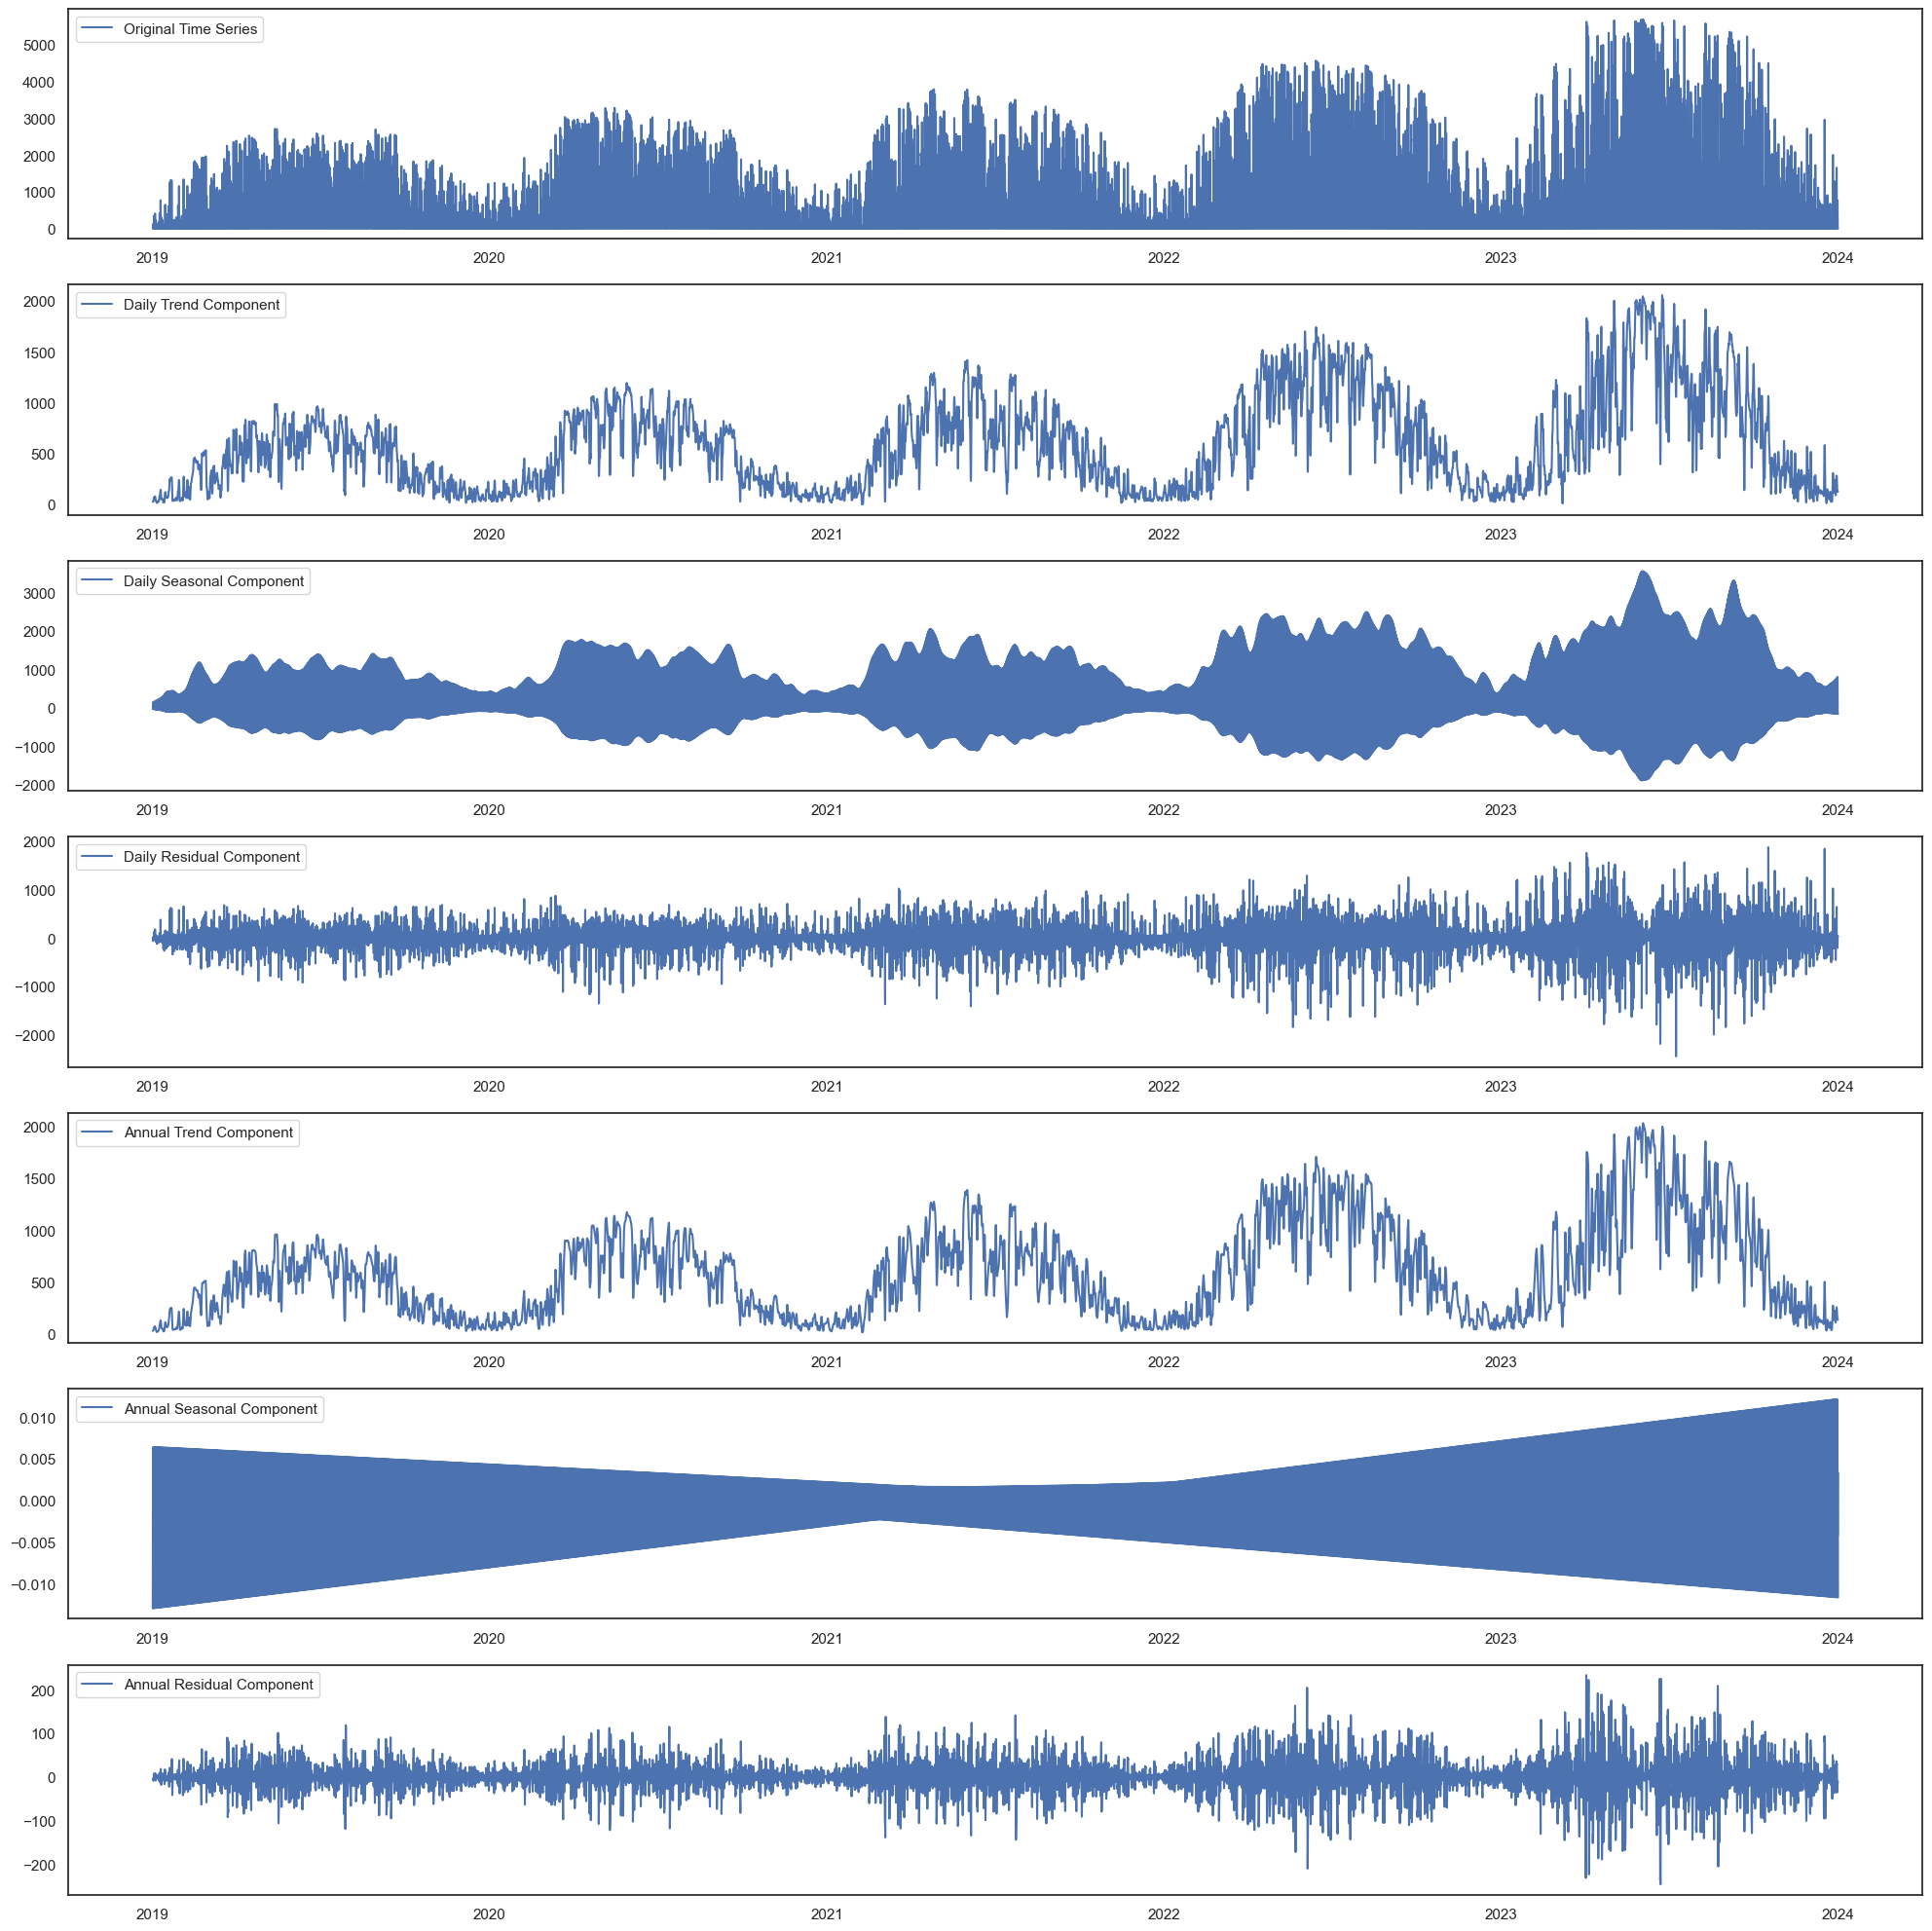

In [188]:
stl_daily = STL(df_be_stl, seasonal=23) # ~24hrs, but needs to be odd - 23 was better than 25
result_daily = stl_daily.fit()

stl_annual = STL(result_daily.trend, seasonal=8759) # £8760hrs / year
result_annual = stl_annual.fit()

daily_trend = result_daily.trend
daily_seasonal = result_daily.seasonal
daily_residual = result_daily.resid

annual_trend = result_annual.trend
annual_seasonal = result_annual.seasonal
annual_residual = result_annual.resid

plt.figure(figsize=(20, 20))
plt.subplot(711)
plt.plot(df_be_stl, label='Original Time Series')
plt.legend(loc='upper left')
plt.subplot(712)
plt.plot(daily_trend, label='Daily Trend Component')
plt.legend(loc='upper left')
plt.subplot(713)
plt.plot(daily_seasonal, label='Daily Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(714)
plt.plot(daily_residual, label='Daily Residual Component')
plt.legend(loc='upper left')
plt.subplot(715)
plt.plot(annual_trend, label='Annual Trend Component')
plt.legend(loc='upper left')
plt.subplot(716)
plt.plot(annual_seasonal, label='Annual Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(717)
plt.plot(annual_residual, label='Annual Residual Component')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

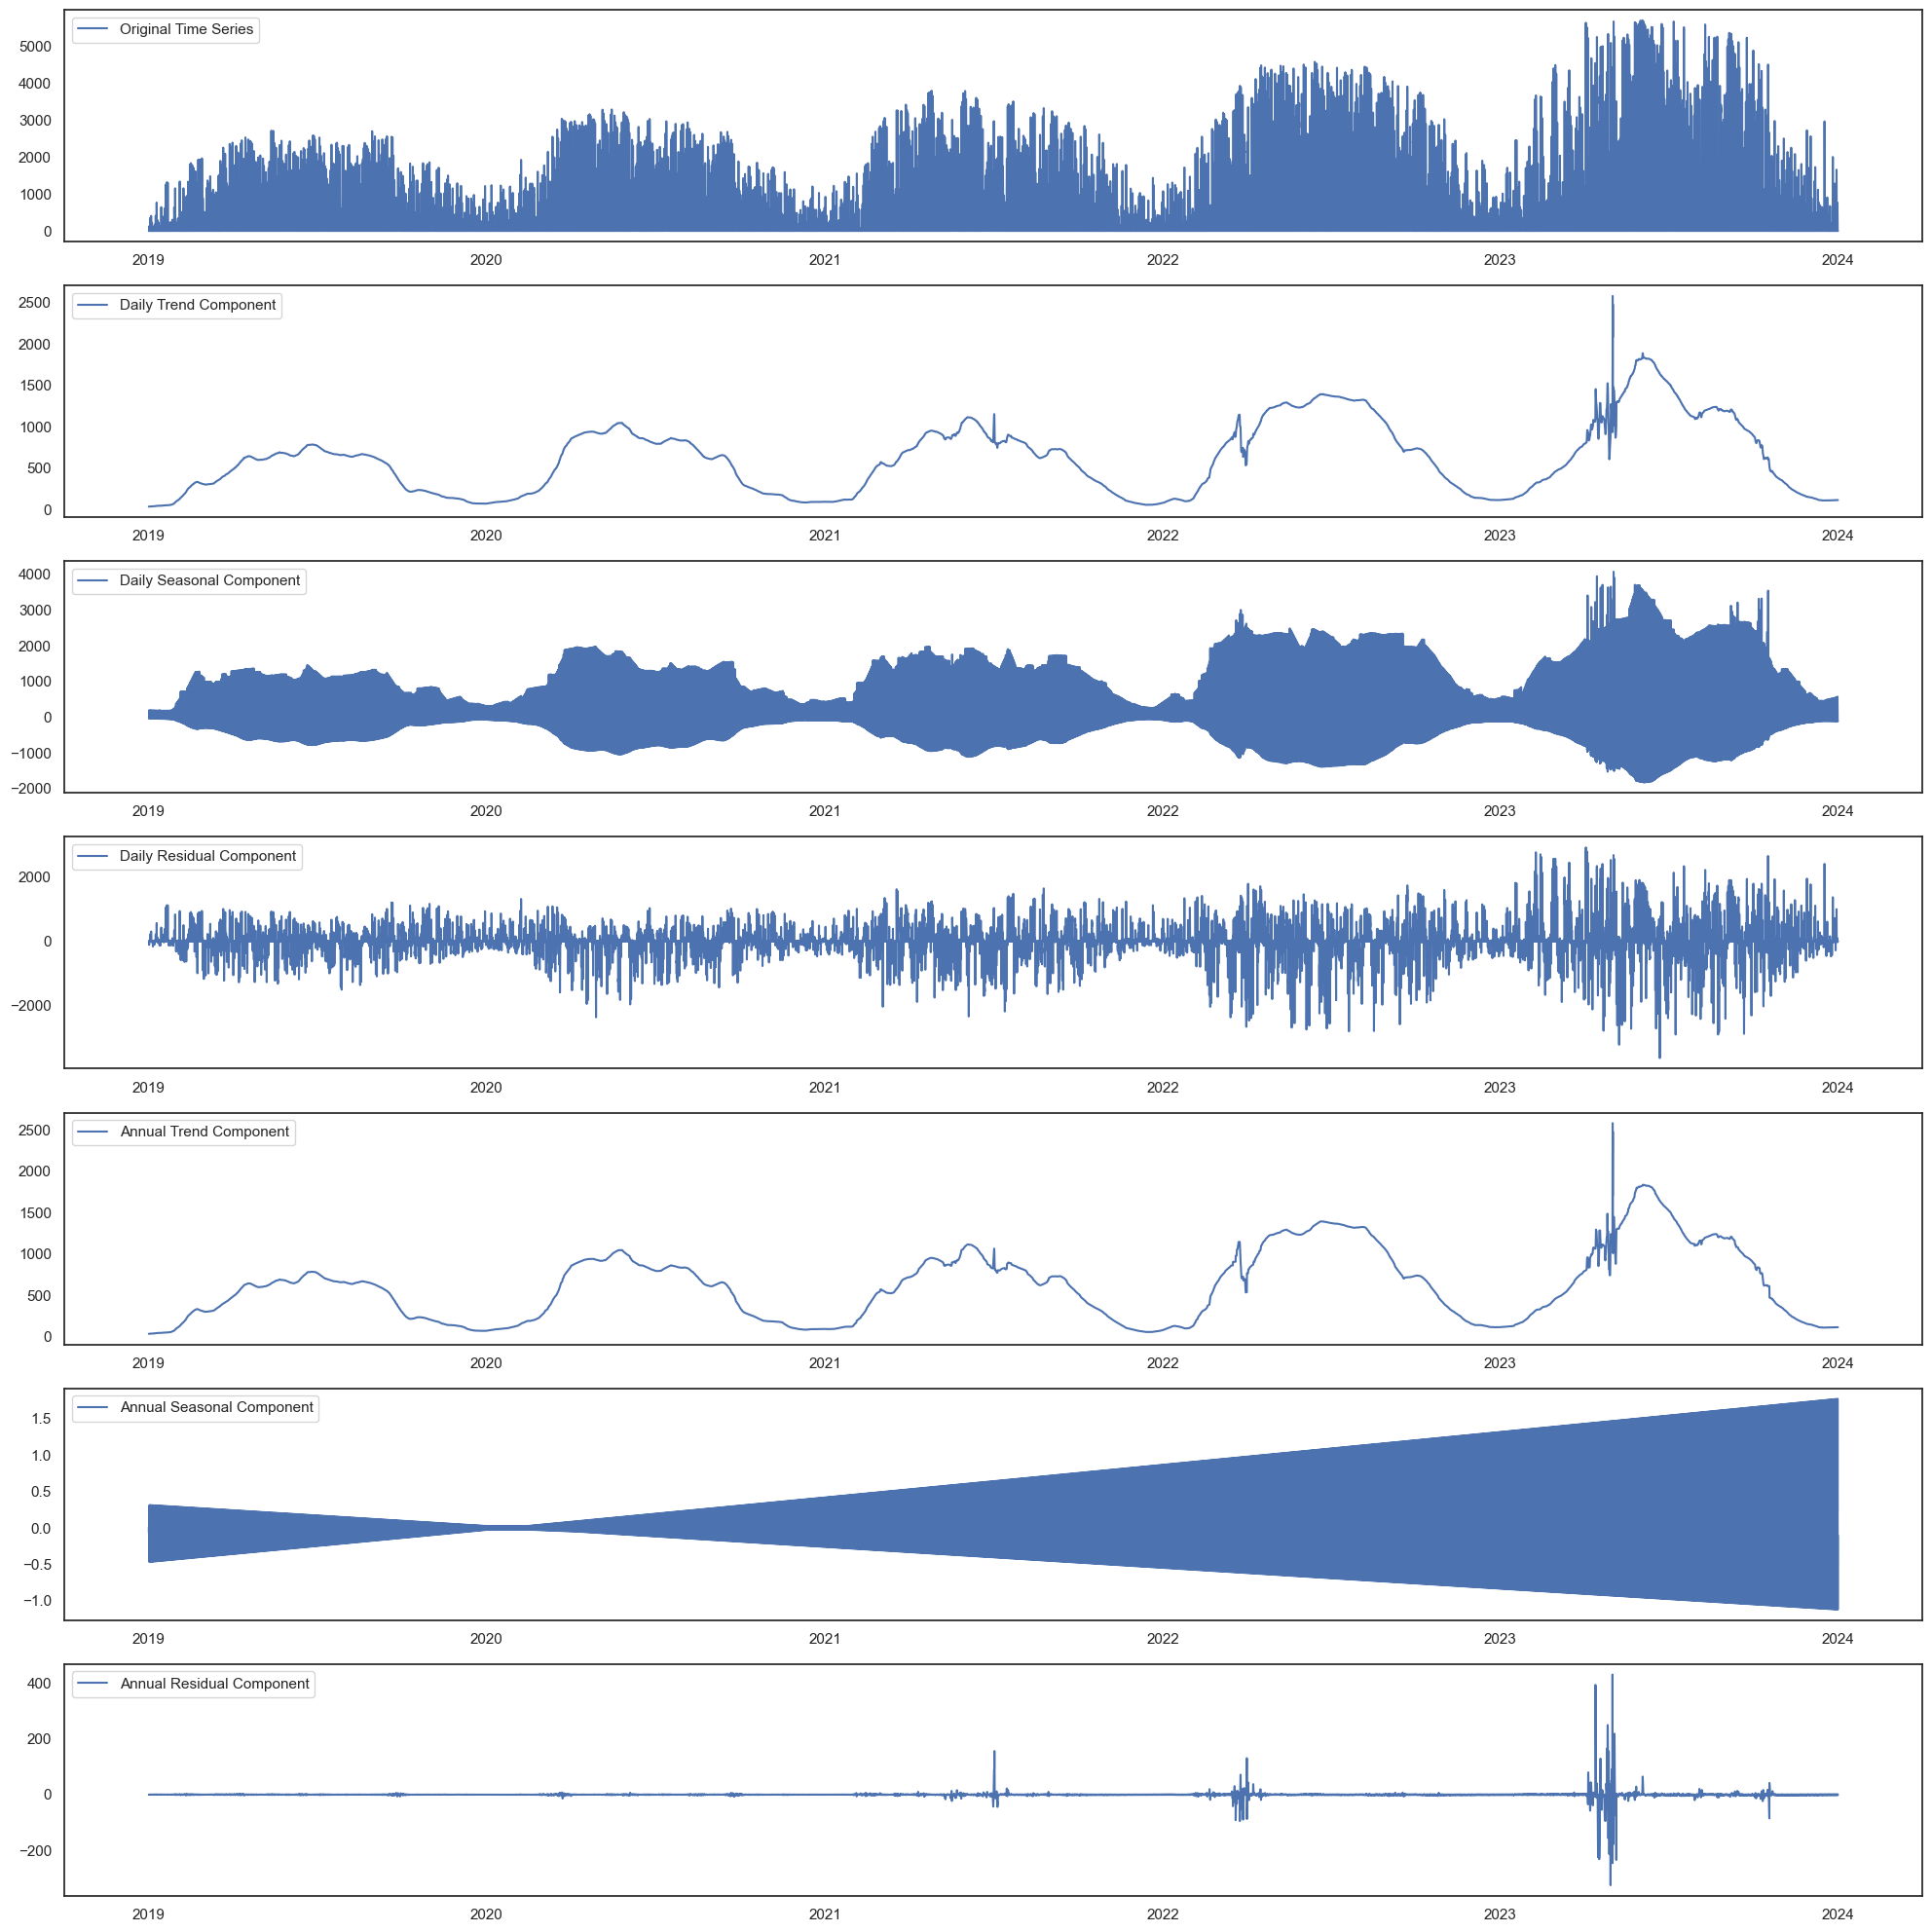

In [190]:
stl_daily = STL(df_be_stl, seasonal=23, robust=True) # ~24hrs, but needs to be odd - 23 was better than 25
result_daily = stl_daily.fit()

stl_annual = STL(result_daily.trend, seasonal=8759, robust=True) # £8760hrs / year
result_annual = stl_annual.fit()

daily_trend = result_daily.trend
daily_seasonal = result_daily.seasonal
daily_residual = result_daily.resid

annual_trend = result_annual.trend
annual_seasonal = result_annual.seasonal
annual_residual = result_annual.resid

plt.figure(figsize=(20, 20))
plt.subplot(711)
plt.plot(df_be_stl, label='Original Time Series')
plt.legend(loc='upper left')
plt.subplot(712)
plt.plot(daily_trend, label='Daily Trend Component')
plt.legend(loc='upper left')
plt.subplot(713)
plt.plot(daily_seasonal, label='Daily Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(714)
plt.plot(daily_residual, label='Daily Residual Component')
plt.legend(loc='upper left')
plt.subplot(715)
plt.plot(annual_trend, label='Annual Trend Component')
plt.legend(loc='upper left')
plt.subplot(716)
plt.plot(annual_seasonal, label='Annual Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(717)
plt.plot(annual_residual, label='Annual Residual Component')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Visualised distributions

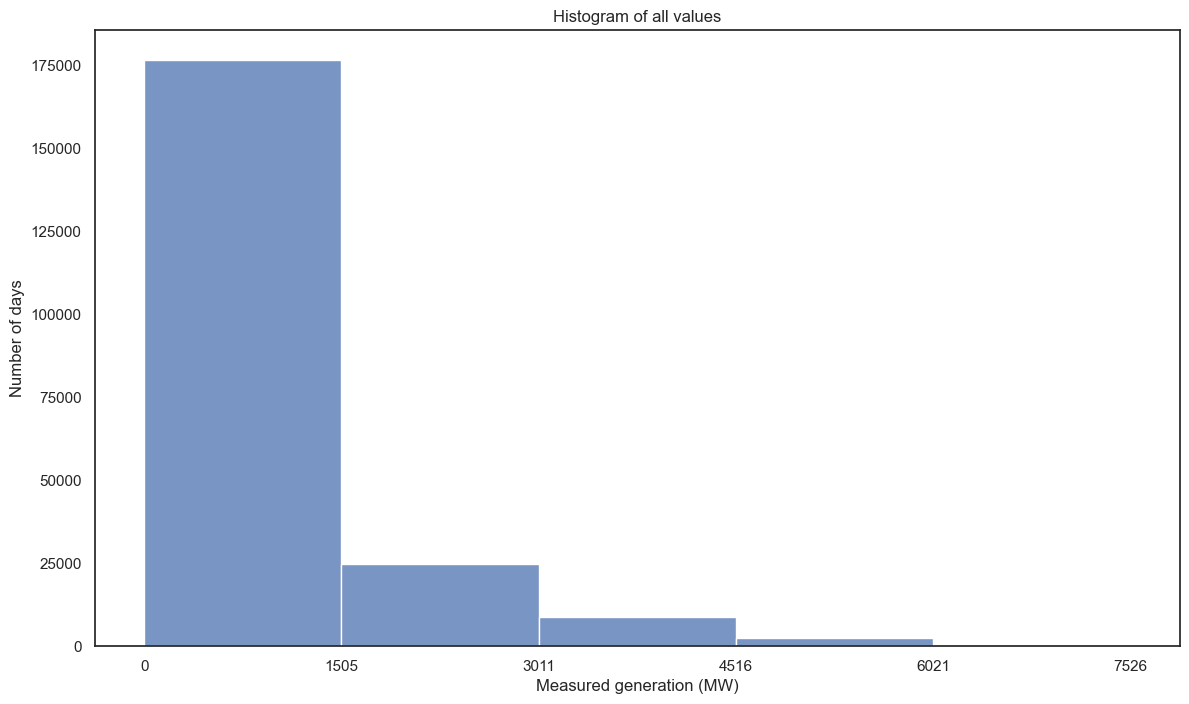

In [204]:
df_be_max = df_be.measured.max()
bins = [0, 0.2*df_be_max, 0.4*df_be_max, 0.6*df_be_max, 0.8*df_be_max, df_be_max]
plt.figure(figsize=(14,8))
sns.histplot(df_be.measured, bins=bins, kde=False)
plt.title('Histogram of all values')
plt.ylabel('Number of days')
plt.xlabel('Measured generation (MW)')
plt.xticks(bins)
plt.show()

In [210]:
df_be[['measured']].resample('D').max()

measured
datetime                           
2018-10-01 00:00:00+00:00  1482.789
2018-10-02 00:00:00+00:00   769.514
2018-10-03 00:00:00+00:00  1728.376
2018-10-04 00:00:00+00:00  1549.359
2018-10-05 00:00:00+00:00  2011.805
...                             ...
2024-10-23 00:00:00+00:00  5115.494
2024-10-24 00:00:00+00:00  5336.580
2024-10-25 00:00:00+00:00  4738.337
2024-10-26 00:00:00+00:00  4744.066
2024-10-27 00:00:00+00:00  3420.513

[2219 rows x 1 columns]

In [213]:
daily_max_df = df_be[['measured']].resample('D').max()
total_max = daily_max_df.measured.max()
bins = [0, 0.2*total_max, 0.4*total_max, 0.6*total_max, 0.8*total_max, total_max]
plt.figure(figsize=(14,8))
sns.histplot(daily_max_df.measured, bins=bins, kde=False)
plt.title('Histogram of daily max values')
plt.ylabel('Number of days')
plt.xlabel('Measured generation (MW)')
plt.xticks(bins)
plt.show()

80-100:	3936
60-80:	14208
40-60:	40704
20-40:	76512
0-20:	77664


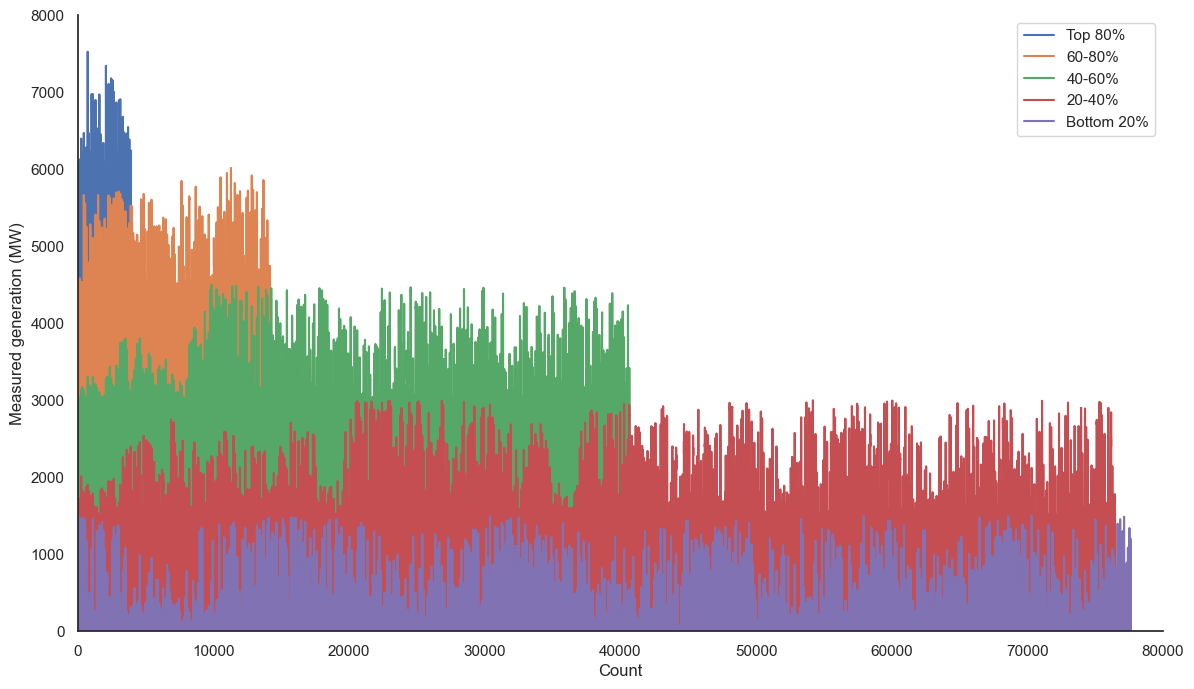

In [203]:
daily_max = df_be.measured.resample('D').max()
total_max = daily_max.max()

pc_80_100 = daily_max[daily_max >= total_max*0.8].index
pc_60_80 = daily_max[(daily_max >= total_max*0.6) & (daily_max < total_max*0.8)].index
pc_40_60 = daily_max[(daily_max >= total_max*0.4) & (daily_max < total_max*0.6)].index
pc_20_40 = daily_max[(daily_max >= total_max*0.2) & (daily_max < total_max*0.4)].index
pc_0_20 = daily_max[(daily_max < total_max*0.2)].index

df_pc_80_100 = df_be[df_be.index.normalize().isin(pc_80_100)]
df_pc_80_100 = df_pc_80_100.reset_index(drop=True)
df_pc_80_100['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_80_100), freq="15min")
df_pc_80_100.reset_index()
print(f'80-100:\t{len(df_pc_80_100)}')

df_pc_60_80 = df_be[df_be.index.normalize().isin(pc_60_80)]
df_pc_60_80 = df_pc_60_80.reset_index(drop=True)
df_pc_60_80.reset_index()
print(f'60-80:\t{len(df_pc_60_80)}')

df_pc_40_60 = df_be[df_be.index.normalize().isin(pc_40_60)]
df_pc_40_60 = df_pc_40_60.reset_index(drop=True)
df_pc_40_60.reset_index()
print(f'40-60:\t{len(df_pc_40_60)}')

df_pc_20_40 = df_be[df_be.index.normalize().isin(pc_20_40)]
df_pc_20_40 = df_pc_20_40.reset_index(drop=True)
df_pc_20_40.reset_index()
print(f'20-40:\t{len(df_pc_20_40)}')

df_pc_0_20 = df_be[df_be.index.normalize().isin(pc_0_20)]
df_pc_0_20 = df_pc_0_20.reset_index(drop=True)
df_pc_0_20.reset_index()
print(f'0-20:\t{len(df_pc_0_20)}')

plt.figure(figsize=(14,8))
sns.lineplot(df_pc_80_100.measured, label='Top 80%')
sns.lineplot(df_pc_60_80.measured, label='60-80%')
sns.lineplot(df_pc_40_60.measured, label='40-60%')
sns.lineplot(df_pc_20_40.measured, label='20-40%')
sns.lineplot(df_pc_0_20.measured, label='Bottom 20%')
sns.despine()
plt.ylabel('Measured generation (MW)')
plt.xlabel('Count')
plt.xlim(0,80000)
plt.ylim(0,8000)
plt.legend(loc='upper right')
plt.show()

## Stationarity

In [218]:
adfuller(df_be.measured, autolag='AIC')

(-11.94507306500257,
 4.449909467141862e-22,
 82,
 212941,
 {'1%': -3.4303807098155406,
  '5%': -2.8615535733366726,
  '10%': -2.5667772245983227},
 2141580.3188957865)

# Their forecasts

### Plots

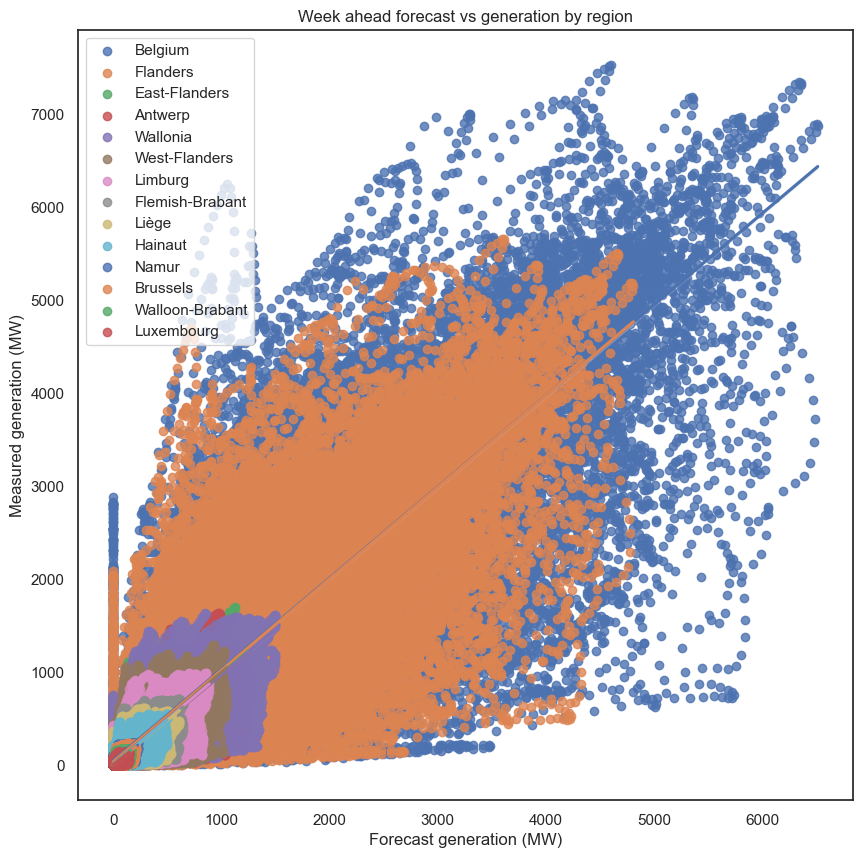

In [219]:
region_max = df.groupby('region').measured.max().sort_values(ascending=False)
plt.figure(figsize=(10, 10))
plt.title('Week ahead forecast vs generation by region')
for region in region_max.index.values:
    ax = sns.regplot(df[df.region==region], y='measured', x='forecast_week', label=region)
plt.ylabel('Measured generation (MW)')
plt.xlabel('Forecast generation (MW)')
plt.legend(loc='upper left')
plt.savefig('week-ahead-forecast-vs-generation-by-region', bbox_inches='tight', transparent=True)
plt.show()

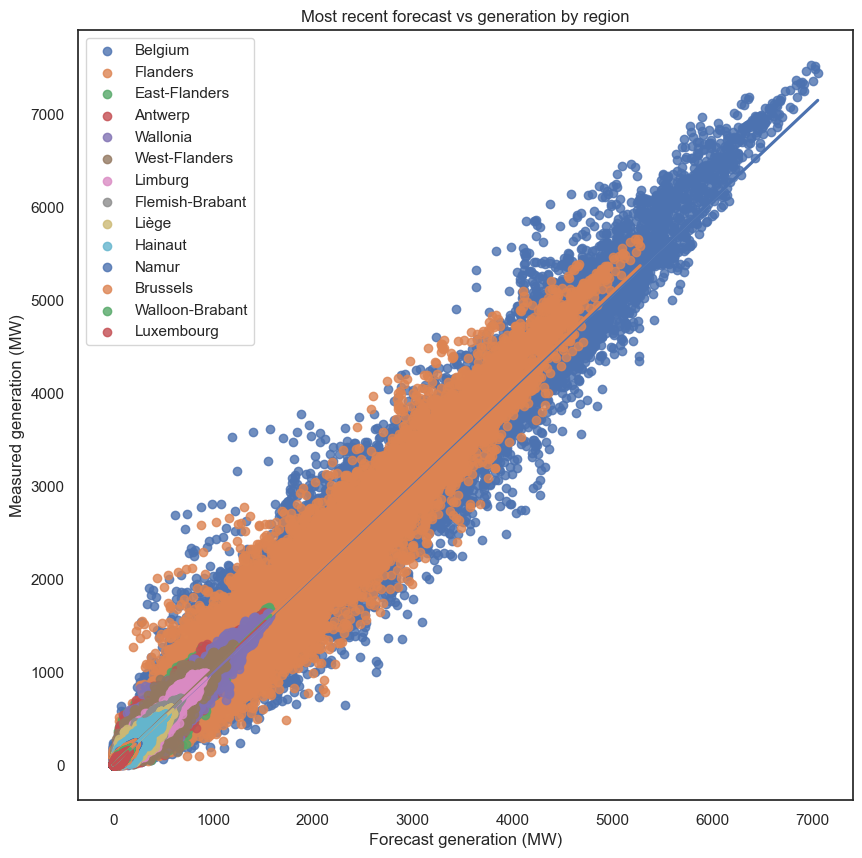

In [220]:
region_max = df.groupby('region').measured.max().sort_values(ascending=False)
plt.figure(figsize=(10, 10))
plt.title('Most recent forecast vs generation by region')
for region in region_max.index.values:
    ax = sns.regplot(df[df.region==region], y='measured', x='forecast_recent', label=region)
plt.ylabel('Measured generation (MW)')
plt.xlabel('Forecast generation (MW)')
plt.legend(loc='upper left')
plt.savefig('most-recent-forecast-vs-generation-by-region', bbox_inches='tight', transparent=True)
plt.show()

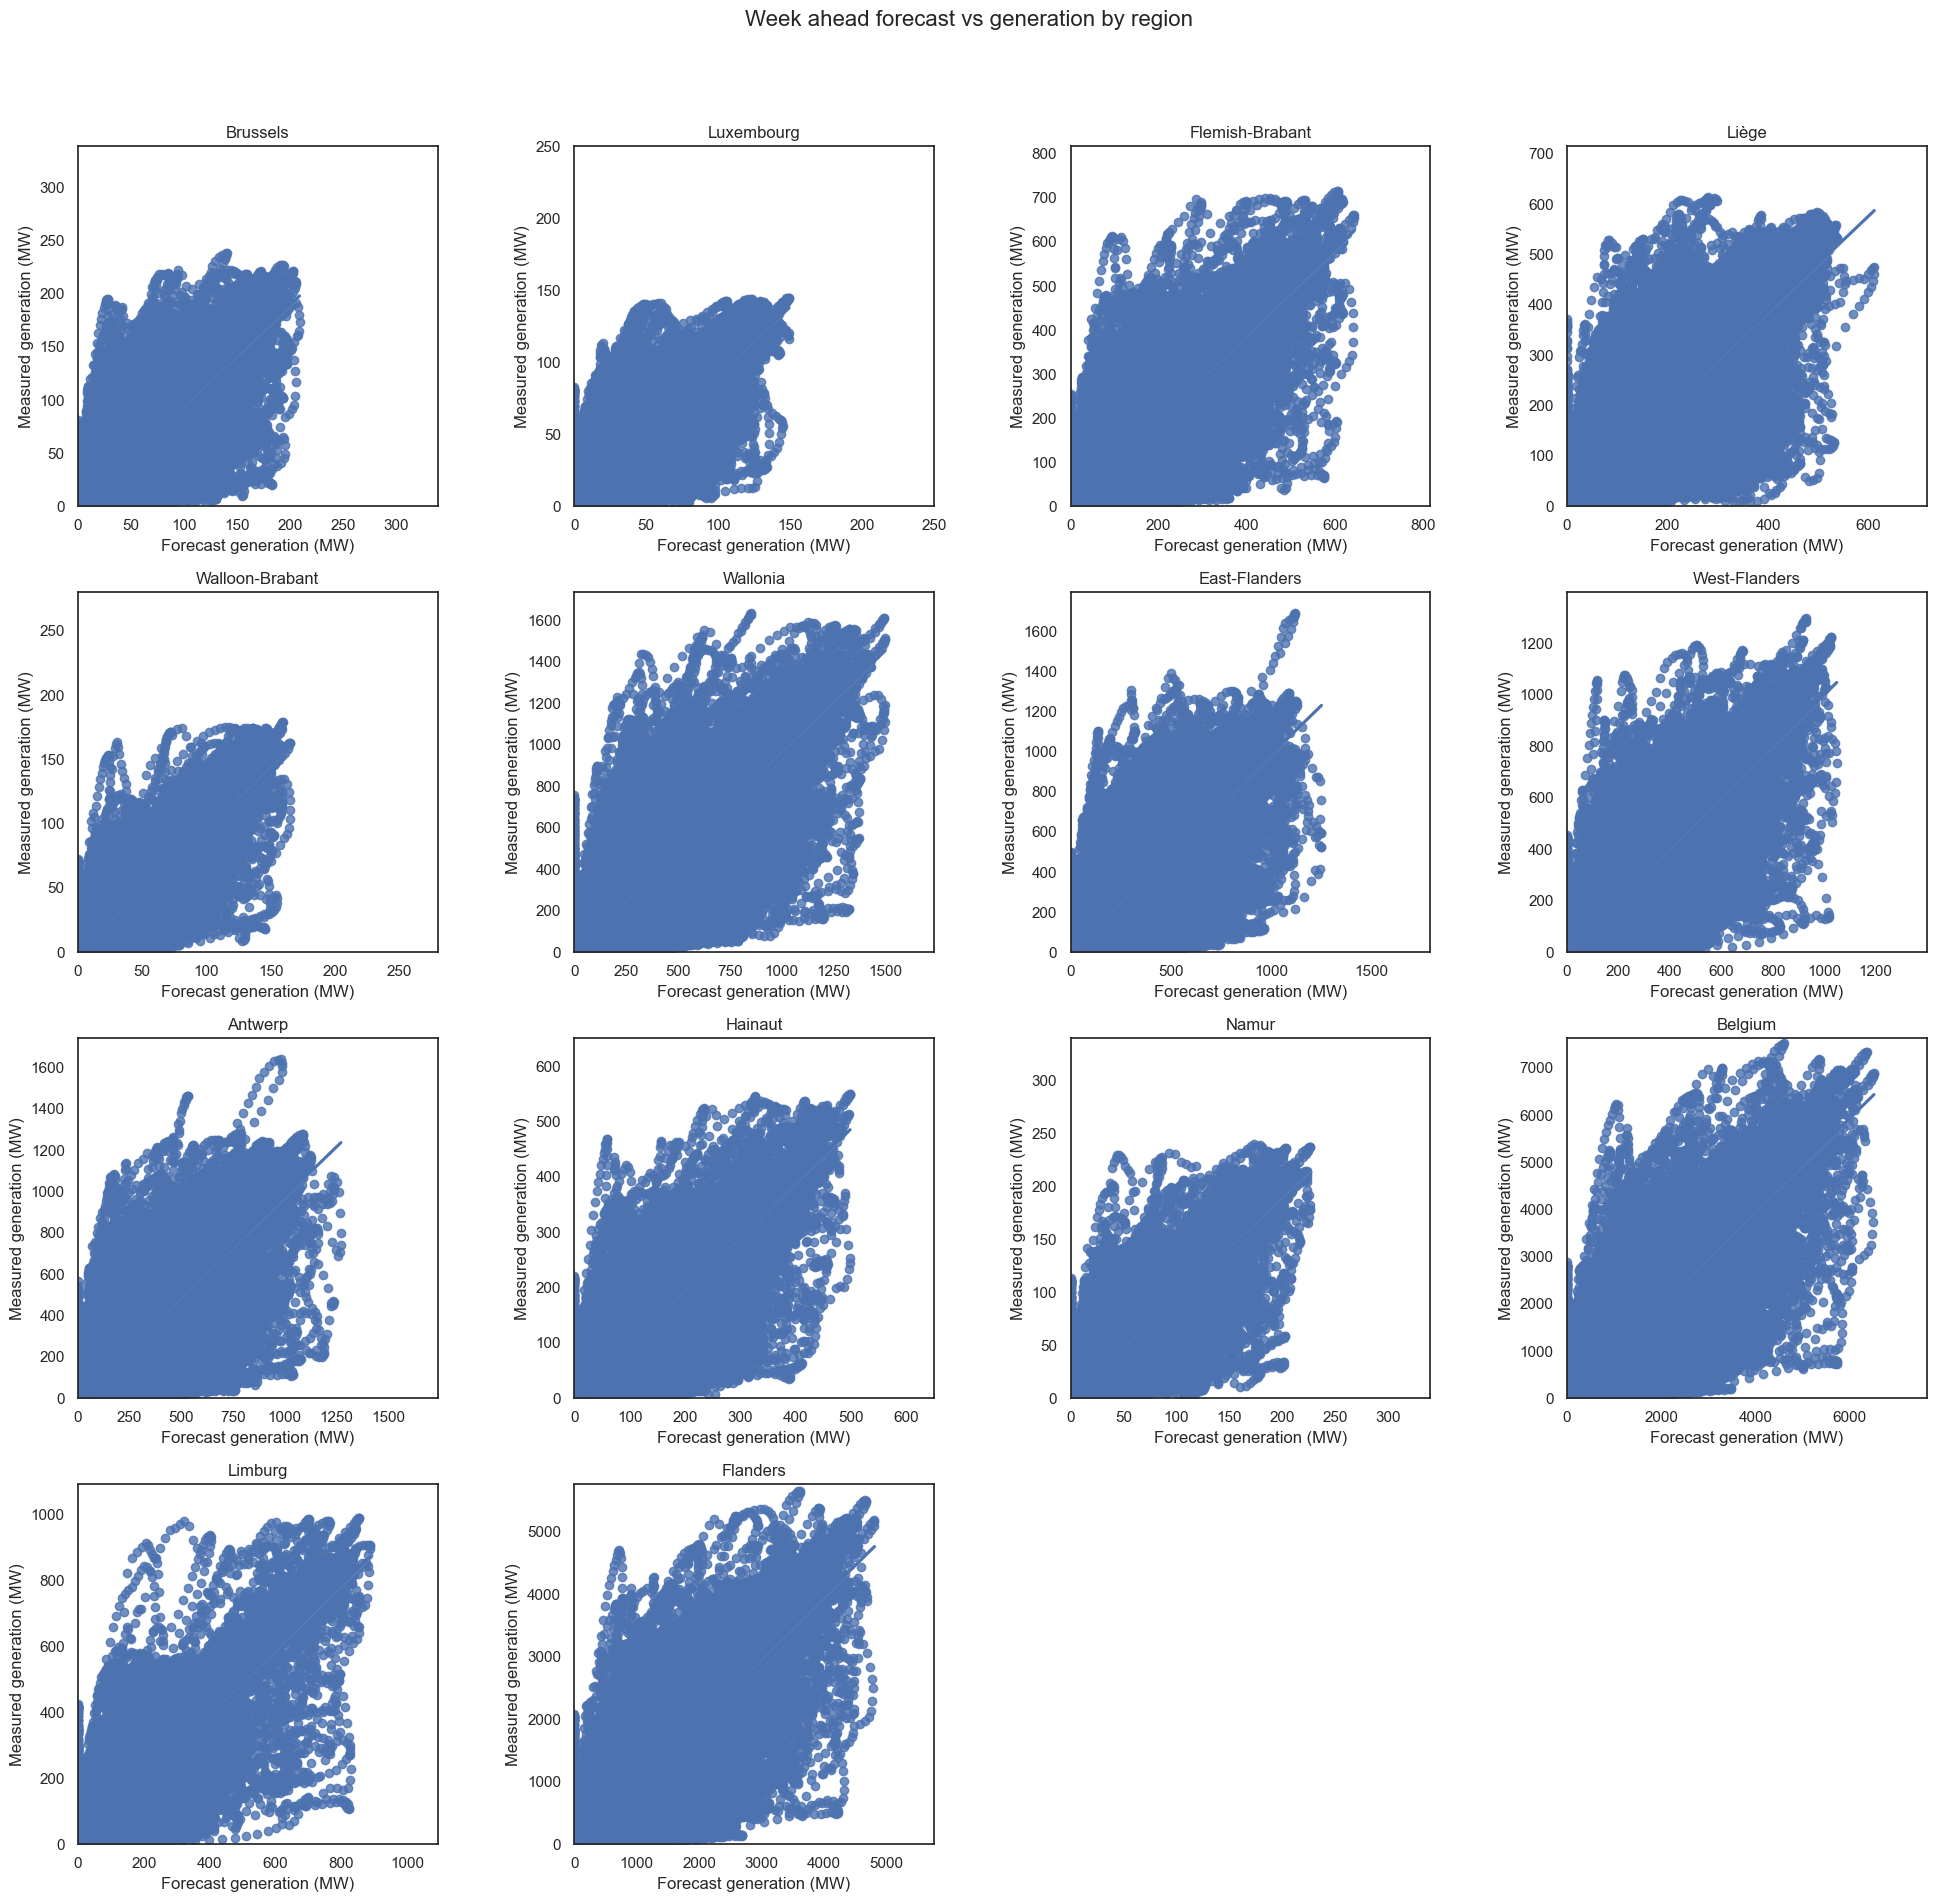

In [221]:
plt.figure(figsize=(20, 20))
plt.suptitle('Week ahead forecast vs generation by region', fontsize=16)

regions = df.region.unique()
rows, cols = 4, 4

for i, region in enumerate(regions, 1):
    # print(region)
    ax = plt.subplot(rows, cols, i)
    region_data = df[df.region == region]
    
    max_value = max(
        region_data.forecast_week.max(),
        region_data.measured.max()
    )
    max_limit = np.ceil(max_value)+100
    
    sns.regplot(data=region_data, 
                x='forecast_week', 
                y='measured')
    plt.title(region)
    plt.ylabel('Measured generation (MW)')
    plt.xlabel('Forecast generation (MW)')
    
    ax.set_xlim(0, max_limit)
    ax.set_ylim(0, max_limit)
    
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('week-ahead-forecast-vs-generation-by-region-split', bbox_inches='tight', transparent=True)
plt.show()

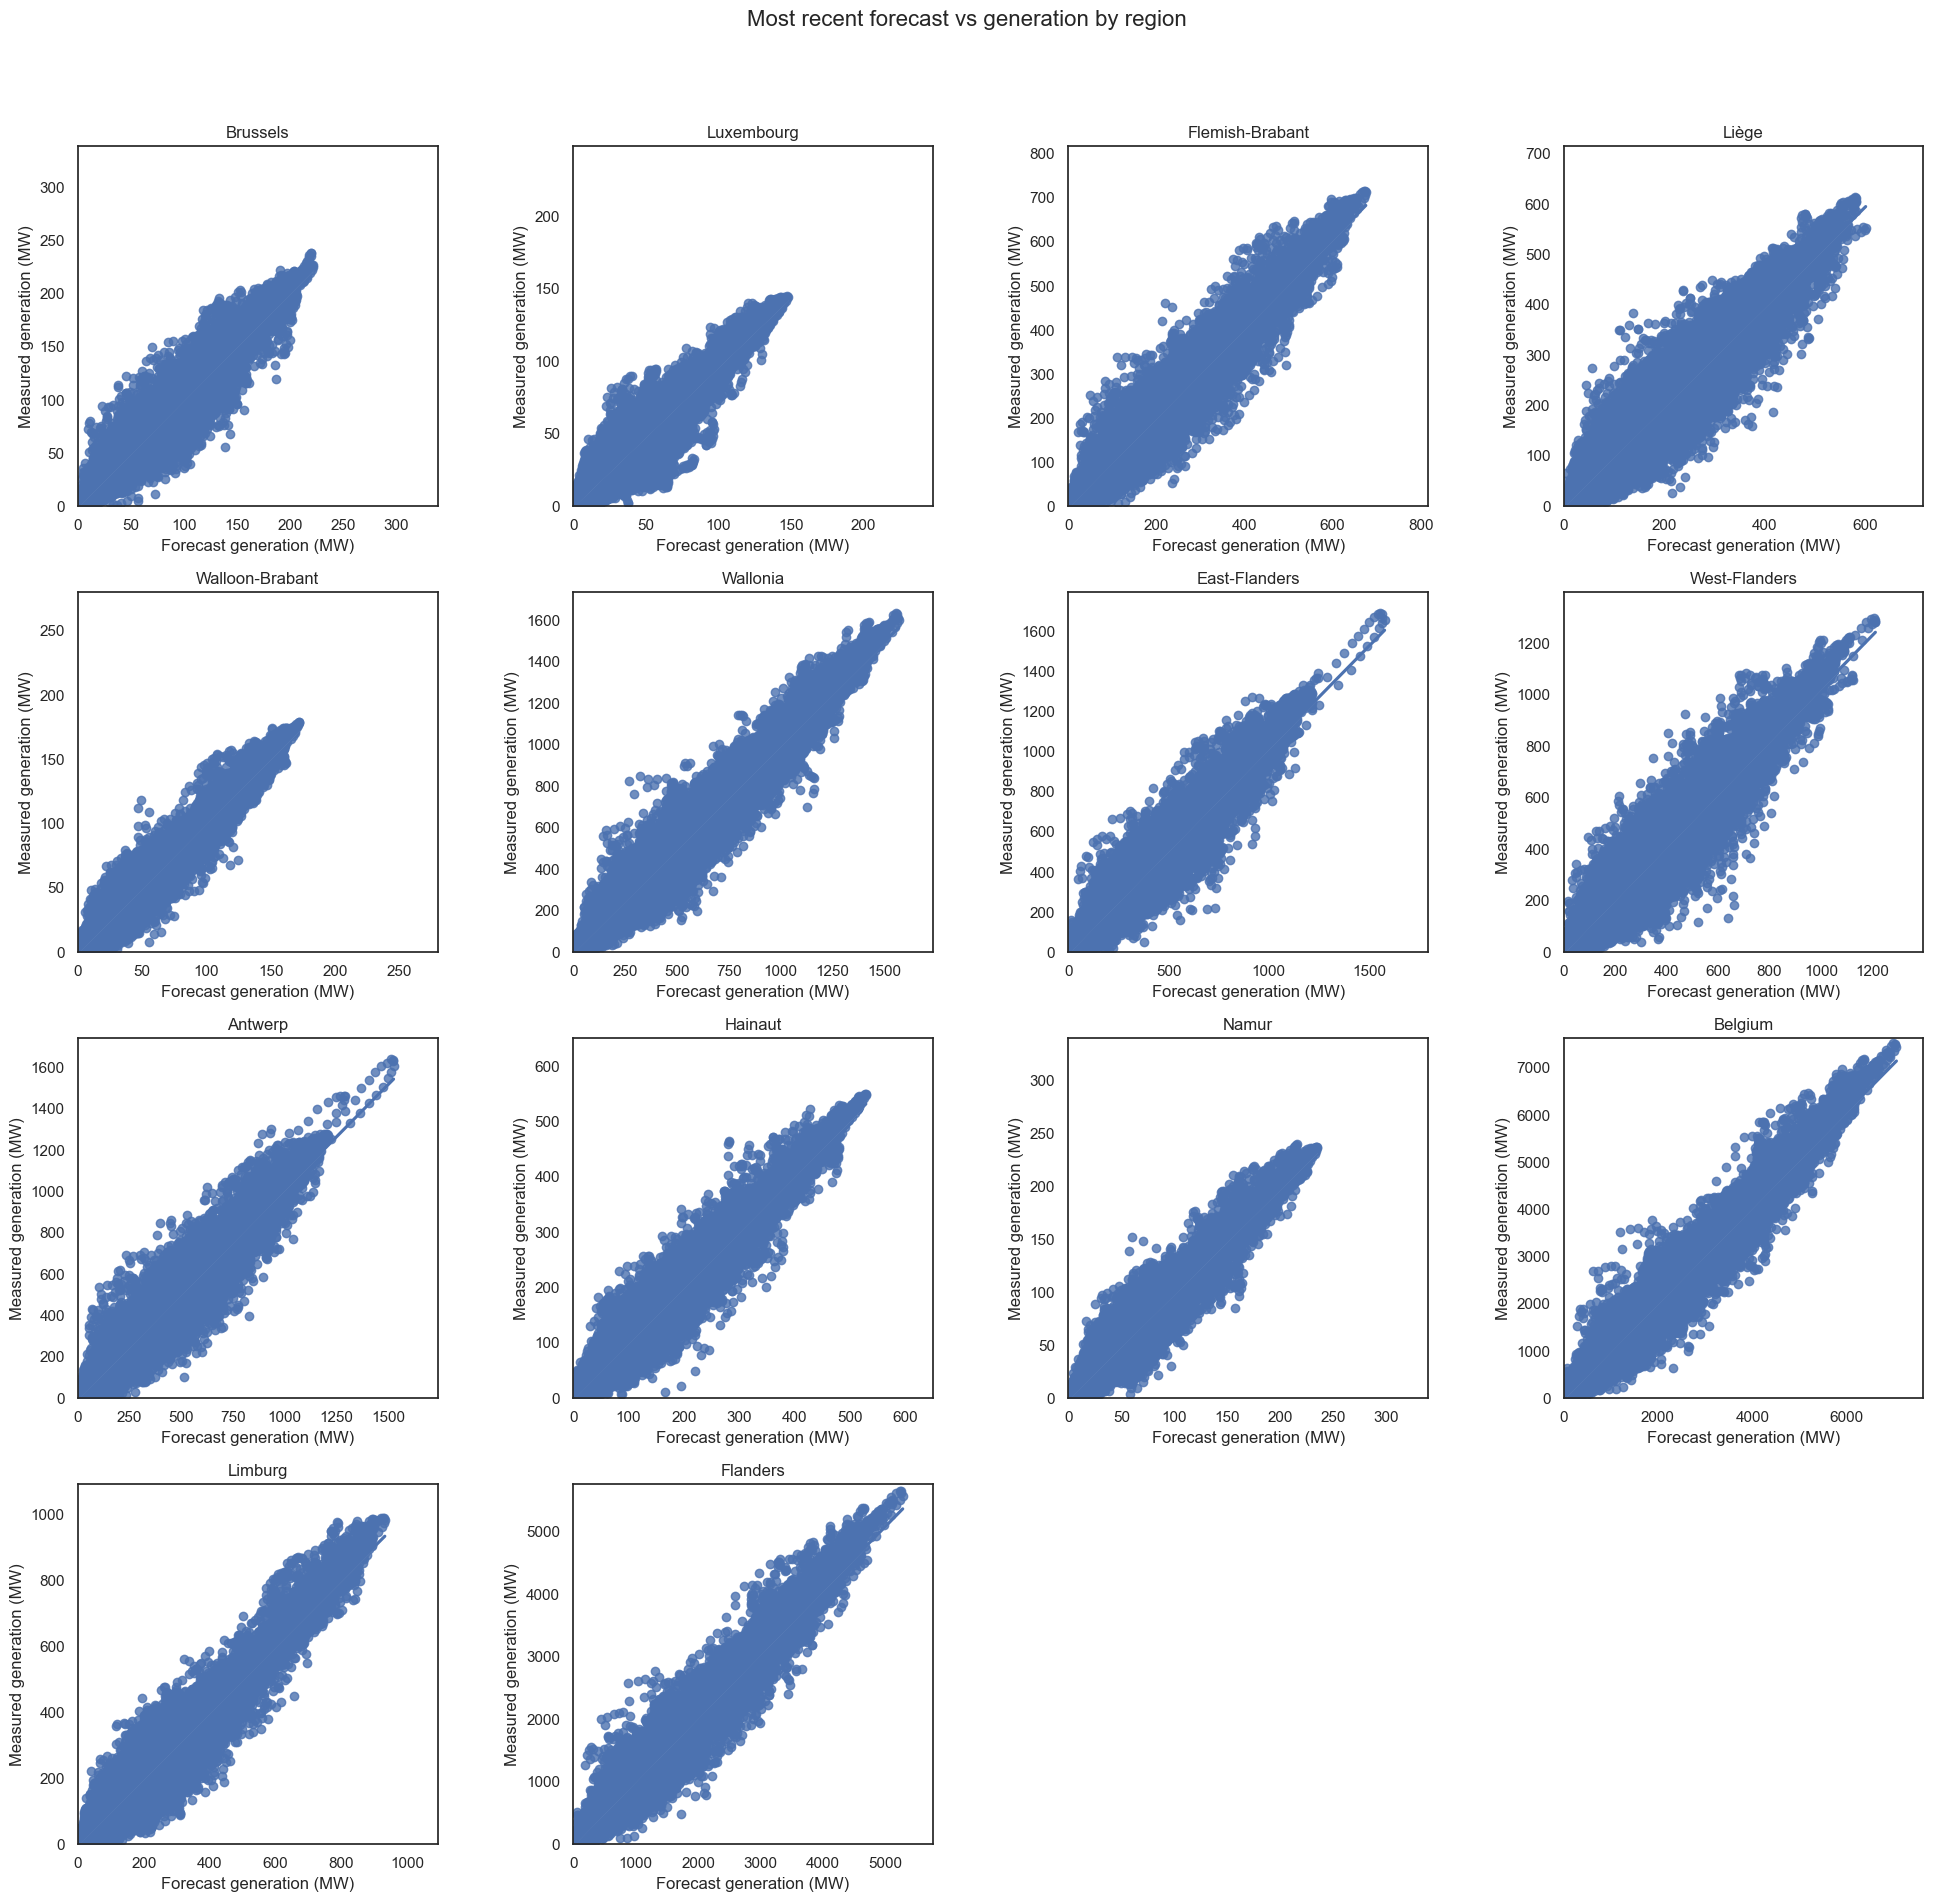

In [222]:
plt.figure(figsize=(20, 20))
plt.suptitle('Most recent forecast vs generation by region', fontsize=16)

regions = df.region.unique()
rows, cols = 4, 4

for i, region in enumerate(regions, 1):
    # print(region)
    ax = plt.subplot(rows, cols, i)
    region_data = df[df.region == region]
    
    max_value = max(
        region_data.forecast_recent.max(),
        region_data.measured.max()
    )
    max_limit = np.ceil(max_value)+100
    
    sns.regplot(data=region_data, 
                x='forecast_recent', 
                y='measured')
    plt.title(region)
    plt.ylabel('Measured generation (MW)')
    plt.xlabel('Forecast generation (MW)')
    
    ax.set_xlim(0, max_limit)
    ax.set_ylim(0, max_limit)
    
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('most-recent-forecast-vs-generation-by-region-split', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
df_be[(df_be.measured > 0) & (df_be.forecast_week == 0)].sort_values('measured')

## Errors

In [22]:
df_errs = df[['region','forecast_week','forecast_recent','measured']]
df_errs = df_errs[df_errs.measured != 0]
df_errs = df_errs.dropna()

df_errs['forecast_week_error'] = df_errs.measured - df_errs.forecast_week
df_errs['forecast_week_error_pc'] = np.divide(
    df_errs.forecast_week_error,
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_week_error),
    where=df_errs.measured != 0
) * 100
df_errs.forecast_week_error_pc = df_errs.forecast_week_error_pc.round(1)

df_errs['forecast_recent_error'] = df_errs.measured - df_errs.forecast_recent
df_errs['forecast_recent_error_pc'] = np.divide(
    df_errs.forecast_recent_error,
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_recent_error),
    where=df_errs.measured != 0
) * 100
df_errs.forecast_recent_error_pc = df_errs.forecast_recent_error_pc.round(1)

df_errs = df_errs[['region','measured', 'forecast_week', 'forecast_week_error', 'forecast_week_error_pc', 'forecast_recent', 'forecast_recent_error', 'forecast_recent_error_pc']]

In [23]:
mean_errors_week = []
mean_errors_recent = []

for i, region in enumerate(df_errs.region.unique()):
    region_data = df_errs[df_errs.region == region]
    week_mean = int(abs(region_data.forecast_week).mean())
    week_mean_error = int(abs(region_data.forecast_week_error).mean())
    week_mean_error_pc = int(region_data.forecast_week_error_pc.mean())
    week_mae = int(mean_absolute_error(region_data.measured, region_data.forecast_week_error))
    week_mape = int(np.where(region_data.measured != 0, np.abs(region_data.forecast_week_error / region_data.measured) * 100, 0).mean())
    recent_mean = int(abs(region_data.forecast_recent_error).mean())
    recent_mean = int(abs(region_data.forecast_recent_error).mean())
    recent_mean_error_pc = int(region_data.forecast_recent_error_pc.mean())
    recent_mae = int(mean_absolute_error(region_data.measured, region_data.forecast_recent_error))
    recent_mape = int(np.where(region_data.measured != 0, np.abs(region_data.forecast_recent_error / region_data.measured) * 100, 0).mean())

    mean_errors_week.append({'region': region, 'Measured': week_mean, 'Error': week_mean_error, '% Error': week_mean_error_pc, 'MAE': week_mae, 'MA%E': week_mape})
    mean_errors_recent.append({'region': region, 'Measured': recent_mean, 'Error': recent_mean, '% Error': recent_mean_error_pc, 'MAE': recent_mae, 'MA%E': recent_mape})

mean_errors_week_df_errs = pd.DataFrame(mean_errors_week)
mean_errors_week_df_errs = mean_errors_week_df_errs.sort_values(by='MA%E', ascending=True)
mean_errors_recent_df_errs = pd.DataFrame(mean_errors_recent)
mean_errors_recent_df_errs = mean_errors_recent_df_errs.sort_values(by='MA%E', ascending=True)

print('Mean absolute values, forecast (period) vs actual generation, all years, by region')
print('Week ahead forecast')
display(mean_errors_week_df_errs)
print()
print('Most recent forecast')
display(mean_errors_recent_df_errs)

Mean absolute values, forecast (period) vs actual generation, all years, by region
Week ahead forecast


region  Measured  Error  % Error   MAE  MA%E
2        Luxembourg        29     10     -113    29   145
1   Walloon-Brabant        26     10     -115    26   149
9          Wallonia       287    103     -119   287   153
0             Liège       112     43     -145   112   179
4             Namur        39     15     -147    39   181
12         Brussels        27     11     -151    27   185
13          Hainaut        84     32     -162    84   196
8           Limburg       142     55     -172   142   207
5   Flemish-Brabant       106     42     -175   106   210
10    East-Flanders       214     85     -210   214   245
7           Belgium      1168    430     -229  1168   263
11    West-Flanders       192     77     -234   192   270
6           Antwerp       212     85     -241   212   275
3          Flanders       857    324     -325   857   360


Most recent forecast


region  Measured  Error  % Error   MAE  MA%E
1   Walloon-Brabant         3      3      -47    27    64
9          Wallonia        30     30      -53   301    69
2        Luxembourg         4      4      -57    30    74
12         Brussels         3      3      -63    28    80
4             Namur         5      5      -65    41    81
0             Liège        15     15      -67   118    85
8           Limburg        19     19      -84   151   101
13          Hainaut        10     10      -86    88   102
5   Flemish-Brabant        13     13      -88   111   104
6           Antwerp        27     27     -113   224   130
7           Belgium       120    120     -121  1229   137
10    East-Flanders        28     28     -129   225   146
11    West-Flanders        29     29     -142   202   162
3          Flanders        94     94     -195   903   212

In [25]:
mean_errors = []


df_errs['year'] = df_errs.index.year
df_errs_filtered = df_errs[(df_errs.year >= 2019) & (df_errs.year <= 2022)]

for year in df_errs_filtered.year.unique():
    year_data = df_errs_filtered[df_errs_filtered.year == year]
    week_mean = int(abs(year_data.forecast_week).mean())
    week_mean_error = int(abs(year_data.forecast_week_error).mean())
    week_mean_error_pc = int(year_data.forecast_week_error_pc.mean())
    week_mae = int(mean_absolute_error(year_data.measured, year_data.forecast_week_error))
    week_mape = int(np.where(year_data.measured != 0, np.abs(year_data.forecast_week_error / year_data.measured) * 100, 0).mean())
    recent_mean = int(abs(year_data.forecast_recent).mean())
    recent_mean_error = int(abs(year_data.forecast_recent_error).mean())
    recent_mean_error_pc = int(year_data.forecast_recent_error_pc.mean())
    recent_mae = int(mean_absolute_error(year_data.measured, year_data.forecast_recent_error))
    recent_mape = int(np.where(year_data.measured != 0, np.abs(year_data.forecast_recent_error_pc / year_data.measured) * 100, 0).mean())
    mean_errors.append({
        'Year': year,
        'Week Measured': week_mean,
        'Week Error': week_mean_error,
        'Week % Error': week_mean_error_pc,
        'Week MAE': week_mae,
        'Week MA%E': week_mape,
        'Recent Measured': recent_mean,
        'Recent Error': recent_mean_error,
        'Recent % Error': recent_mean_error_pc,
        'Recent MAE': recent_mae,
        'Recent MA%E': recent_mape
    })

mean_errors_df_errs = pd.DataFrame(mean_errors)
mean_errors_df_errs = mean_errors_df_errs.melt(id_vars='Year', var_name='Error', value_name='Value')
mean_errors_df_errs = mean_errors_df_errs.pivot(index='Error', columns='Year', values='Value')
mean_errors_df_errs = mean_errors_df_errs.reindex(['Week Measured', 'Week Error', 'Week % Error', 'Week MAE', 'Week MA%E', 'Recent Measured', 'Recent Error', 'Recent % Error', 'Recent MAE', 'Recent MA%E'])

print('Mean absolute forecast values, forecast (period) vs actual generation, all regions, by year')
display(mean_errors_df_errs)

Mean absolute forecast values, forecast (period) vs actual generation, all regions, by year


Year                 2019       2020       2021       2022
Error                                                     
Week Measured       160.0      193.0      195.0      270.0
Week Error           55.0       63.0       80.0      102.0
Week % Error       -150.0     -151.0     -141.0     -115.0
Week MAE            160.0      193.0      195.0      270.0
Week MA%E           179.0      179.0      180.0      153.0
Recent                NaN        NaN        NaN        NaN
Recent Error         21.0       23.0       27.0       28.0
Recent % Error      -87.0      -67.0      -66.0      -75.0
Recent MAE          170.0      199.0      216.0      303.0
Recent MA%E     3404343.0  2834165.0  3042062.0  3138066.0

In [26]:
total_non_zero = df_errs.measured[df_errs.measured != 0].count()
print(f'Total non-zero data\t\t{total_non_zero:,}')
print(f'Week forecast error positive:\t{int((df_errs.forecast_week_error_pc[df_errs.forecast_week_error_pc > 0].count())/total_non_zero*100)}%')
print(f'Week forecast error negative:\t{int((df_errs.forecast_week_error_pc[df_errs.forecast_week_error_pc < 0].count())/total_non_zero*100)}%')
print(f'Recent forecast error positive:\t{int((df_errs.forecast_recent_error_pc[df_errs.forecast_recent_error_pc > 0].count())/total_non_zero*100)}%')
print(f'Recent forecast error negative:\t{int((df_errs.forecast_recent_error_pc[df_errs.forecast_recent_error_pc < 0].count())/total_non_zero*100)}%')


Total non-zero data		1,530,969
Week forecast error positive:	53%
Week forecast error negative:	46%
Recent forecast error positive:	46%
Recent forecast error negative:	52%


Recent forecast error statistics
Mean:		265
Median:		72
Std dev:	558
IQR:		229
MAD:		98


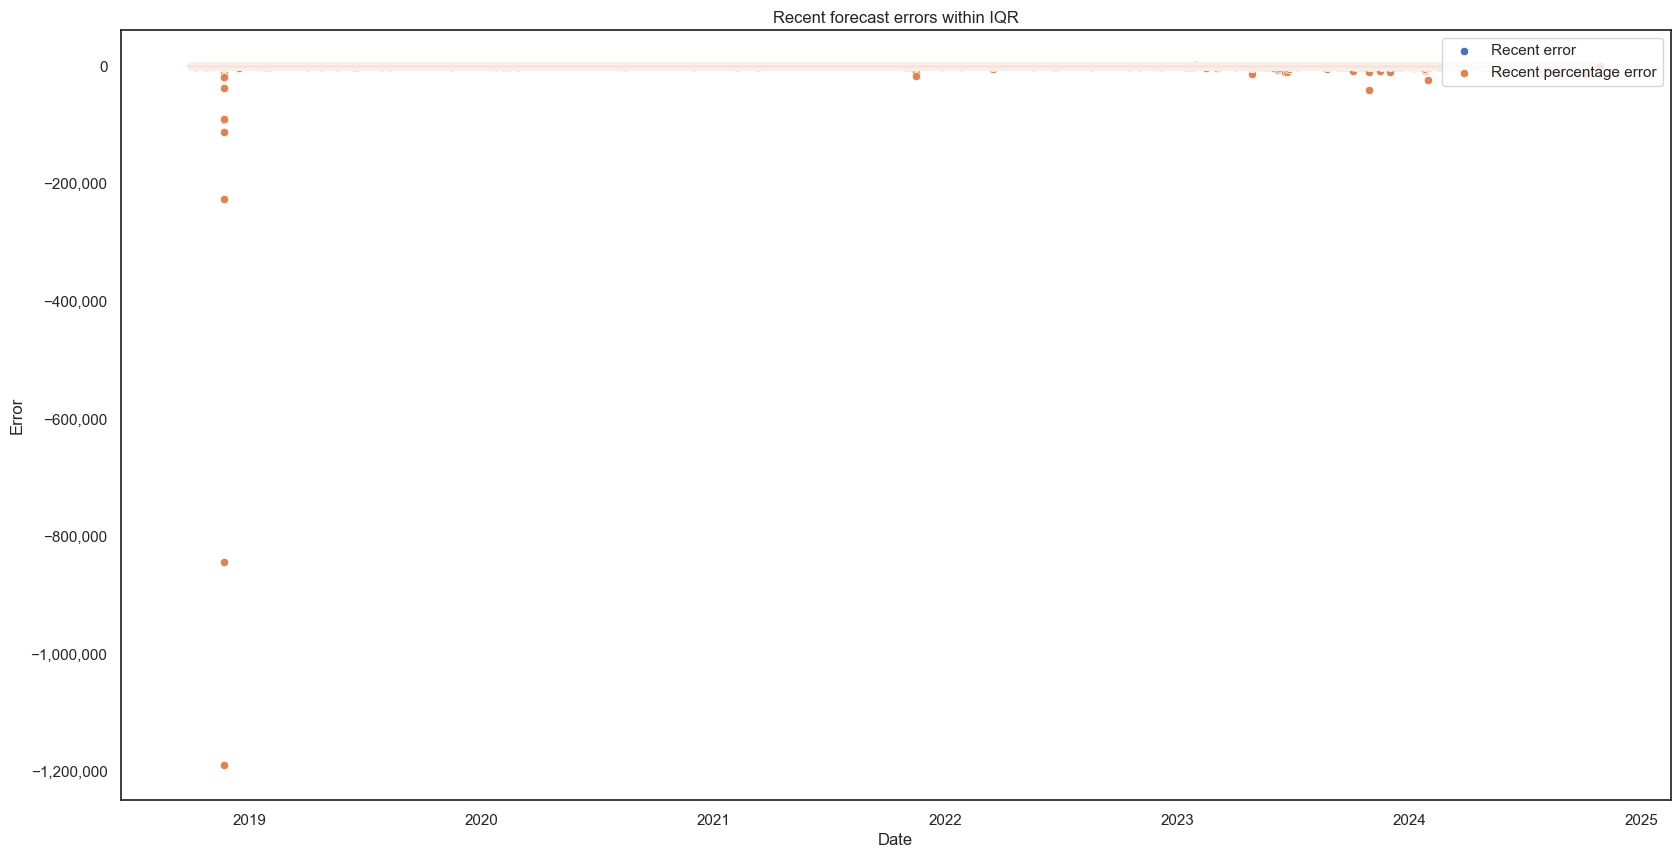

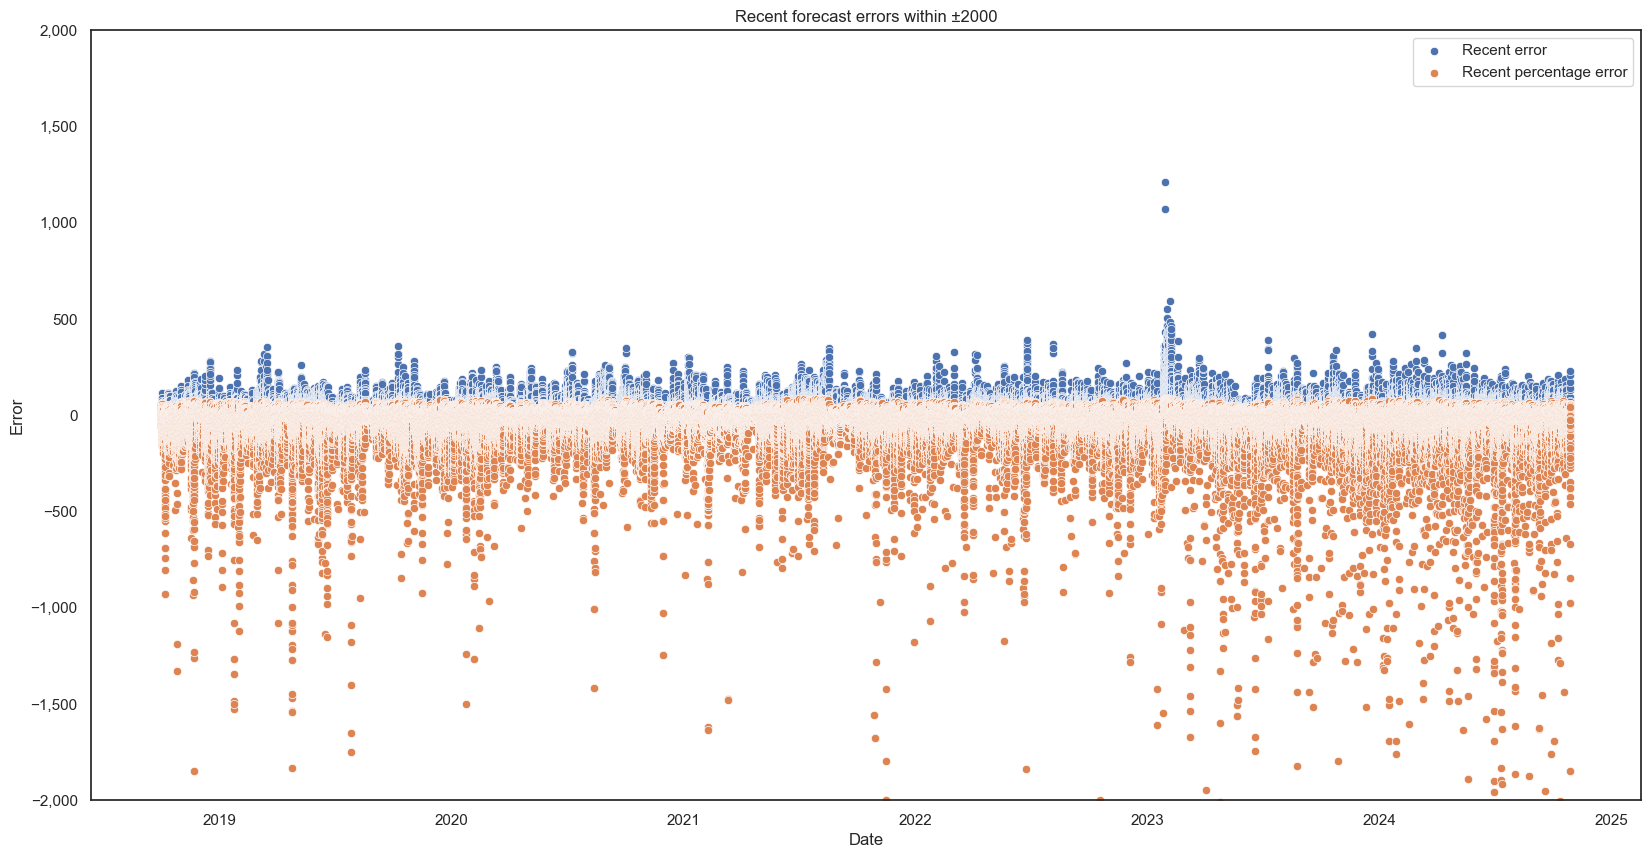

In [27]:
print('Recent forecast error statistics')
stats_errs = df_errs.forecast_recent.agg(['mean', 'median', 'std'])
print(f"Mean:\t\t{int(stats_errs.get('mean'))}")
print(f"Median:\t\t{int(stats_errs.get('median'))}")
print(f"Std dev:\t{int(stats_errs.get('std'))}")
q1 = df_errs.forecast_recent.quantile(0.25)
q3 = df_errs.forecast_recent.quantile(0.75)
print(f"IQR:\t\t{int(q3-q1)}")
print(f"MAD:\t\t{int(mad(df_errs.forecast_recent))}")

df_errs_iqr = df_errs[(df_errs.forecast_recent >= q1) & (df_errs.forecast_recent <= q3)]

plt.figure(figsize=(20,10))
plt.title('Recent forecast errors within IQR')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error', label='Recent error')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
plt.ylabel('Error')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(20,10))
plt.title('Recent forecast errors within ±2000')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error', label='Recent error')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
plt.ylabel('Error')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.ylim(-2000,2000)
plt.show()

# Modelling

In [146]:
start = '2024-06-03'
back = 7
pred = 7
sm = 4
sa = 4
m = int(96/4/sa)
arima_file_title = f'belgium_{start}_{back}d_{pred}d_arima_sm{sm}sa{sa}'
tf_file_title = f'belgium_{start}_{back}d_{pred}d_tf'
arima_plot_title = f'TF Belgium, {back}d history, {pred}d forward (sm{sm}sa{sa})' # disabled with current plot_pred
tf_plot_title = f'TF Belgium, {back}d history, {pred}d forward'

## ARIMA

In [147]:
df_be_arima = df_be[['measured','forecast_week']].copy()

def plot_input(df_in):
    plt.figure(figsize=(20,8))
    sns.lineplot(df_in.measured, color = 'black', label='Actual')
    plt.show()

def plot_pred(df_pred, df_f_in, plot_title, file_title):
    plt.figure(figsize=(20,10))
    sns.lineplot(df_f_in.measured, color = 'black', label='Actual')
    sns.lineplot(df_f_in.forecast_week, color='grey', alpha=0.5, label='Their week-ahead forecast')
    sns.lineplot(df_pred[0], color = 'red', label='My forecast')
    sns.despine()
    plt.xlabel('')
    plt.ylabel('Generation (MW)')
    # plt.ylim(0,6000) # only for sliding window
    plt.legend(loc='upper left')
    plt.title(plot_title)
    plt.savefig(f'{file_title}', bbox_inches='tight', transparent=True)
    plt.show()

def run_model(df_in=df_be_arima, start='2023-06-01', back=7, pred=7, reduce='both', sa=4, sm=4, m=6, trace=True, stats=True, plot=True, plot_amount='all', plot_title='', save=False, file_title=''):
    start_date = pd.to_datetime(start).tz_localize('UTC')
    end_backward = start_date - pd.Timedelta(minutes=15)
    start_backward = end_backward - pd.Timedelta(days=back) + pd.Timedelta(minutes=15)
    end_forward = start_date + pd.Timedelta(days=pred) - pd.Timedelta(minutes=15)
    df_bwd = df_in[start_backward:end_backward]
    df_fwd = df_in[start_date:end_forward]
    df_all = df_in[start_backward:end_forward]

    _ = ''
    if reduce == 'sample':
        if sa > 0 and sa < 1:
            df_run, daily_samples, r = resample_m(df_bwd, sa)
            df_f, _, _ = resample_m(df_fwd, sa)
        else:
            df_run, daily_samples, r = resample_h(df_bwd, sa)
            df_f, _, _ = resample_h(df_fwd, sa)
    elif reduce == 'smooth':
        df_run = smooth_ma(df_bwd, sm)
        df_f = df_fwd
        daily_samples = 96
        r = f'{sm}x'
    elif reduce == 'both':
        df_run, daily_samples, r = resample_h(smooth_ma(df_bwd, sm), sa)
        df_f, _, _ = resample_h(smooth_ma(df_fwd, sm), sa)
    elif reduce == 'none':
        df_run = df_bwd
        df_f = df_fwd
        daily_samples = 96
        r = 'N/A'
    del _
    
    pred_periods = int(daily_samples*pred)

    if reduce == 'sample':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
    elif reduce == 'smooth':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {r}, with {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
    elif reduce == 'both':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {sm}x, then sampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
    elif reduce == 'none':
        print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')

    # plot_input(df_run)

    if trace:
        model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True, trace=True)
    else:
        model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True)
    
    df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=pred_periods))
    df_auto_pred = df_auto_pred.clip(lower=0)
    # df_auto_pred.index = df_auto_pred.index + pd.Timedelta(hours=sa/2) # to centralise samples

    if stats:
        print()
        display(pred_vs_actual_stats(df_auto_pred, df_f))

    if plot:
        if plot_amount == 'all':
            plot_pred(df_auto_pred, df_all, plot_title, file_title)
        elif plot_amount == 'future':
            plot_pred(df_auto_pred, df_f, plot_title, file_title)

    if save:
        with open(f'{file_title}.pkl', 'wb') as f:
            pickle.dump(model_auto, f)

    return model_auto, df_auto_pred

7 days of data, from 2024-05-27 to 2024-06-02
smoothed at 4x, then sampled at 4h, giving 42 values (6/day)
with a seasonal period of 6 (1 days)
with 42 predictons (7 days), until 2024-06-09

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=693.361, Time=1.23 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=726.481, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=691.990, Time=0.86 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=697.459, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=748.180, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=720.548, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[6] intercept   : AIC=688.630, Time=1.87 sec
 ARIMA(1,0,0)(2,0,1)[6] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=688.781, Time=0.52 sec
 ARIMA(0,0,0)(2,0,0)[6] intercept   : AIC=696.975, Time=0.48 sec
 ARIMA(2,0,0)(2,0,0)[6] intercept   : AIC=694.027, Time=0.64 sec
 ARIMA(1,0,1)(2,0,0)[6] intercept   : AIC=686.483, Time

None

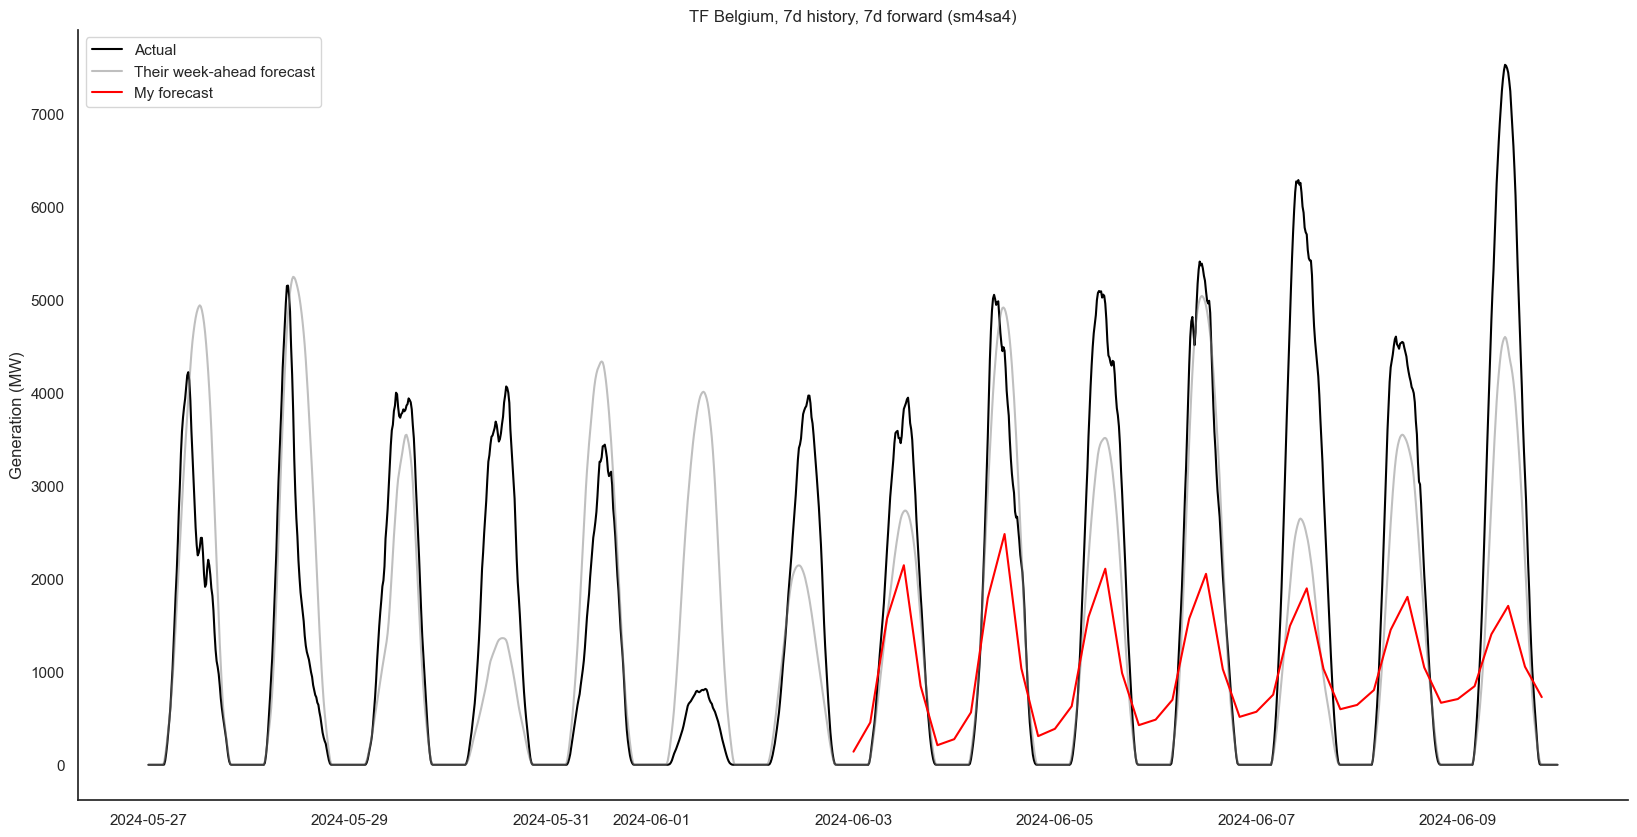

In [151]:
model_arima, pred_arima = run_model(df_in=df_be_arima, start=start, back=back, pred=pred, reduce='both', sm=sm, sa=sa, m=m, trace=True, stats=True, plot=True, plot_amount='all', plot_title=arima_plot_title, save=False, file_title=arima_file_title)

### Sliding window

In [203]:
# Chart upper limit
df_be_arima.measured['2022-01-01':'2023-12-31'].max()

5709.982

In [ ]:
back = 7
pred = 7
sm = 2
sa = 2
m = int(96/4/sa)
date_array = pd.date_range(start='2022-02-18', end='2023-12-31', freq='D').strftime('%Y-%m-%d').tolist()
print(len(date_array))
back = 7
pred = 7
for date in date_array:
    file_title = f'slide/belgium_{date}_{back}d_{pred}d_arima_sm{sm}sa{sa}'
    model_arima, pred_arima = run_model(df_in=df_be_arima, start=date, back=back, pred=pred, reduce='both', sm=sm, sa=sa, m=m, trace=False, stats=False, plot=True, plot_amount='all', save=True, file_title=file_title)

In [67]:
def create_sequences(data, days):
    """
    Create input-output pairs for time series data for an LSTM model.
    
    Parameters:
    - data: Array-like time series data.
    - seq_len: Length of each input sequence.
    
    Returns:
    - X: Array of input sequences of shape (num_samples, seq_len, 1).
    - y: Array of target values of shape (num_samples, 1).
    """
    X, y = [], []
    
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    
    # Convert to numpy arrays and reshape for LSTM input
    X = np.array(X).reshape(-1, seq_len, 1)
    y = np.array(y).reshape(-1, 1)
    
    return X, y
    
df_be_arima_swcv = df_be_arima['2023-01-01':'2023-12-31']

train_window = 4 * 7 * 96
test_window = 7 * 96

errors = []

for start in range(0, len(df_be_arima_swcv) - train_window - test_window, test_window):
    train_data = df_be_arima_swcv.measured.values[start : start + train_window]
    test_data = df_be_arima_swcv.measured.values[start + train_window : start + train_window + test_window]

    X_train, y_train = create_sequences(train_data, seq_len)
    X_test, y_test = create_sequences(test_data, seq_len)

    model_arima.fit(X_train, y_train)
    predictions = model_arima.predict(X_test)

    error = mean_squared_error(y_test, predictions)
    errors.append(error)

print("Average Cross-Validation Error:", np.mean(errors))

## Keras

### Preprocess data

In [190]:
# start = '2024-01-01'
# back = (365*4)+1
# pred = 366
start = '2023-06-01'
back = 7
pred = 7
tf_file_title = f'tf_belgium_{start}_{back}d_{pred}d'
tf_plot_title = f'TF Belgium, one month history, one week forward'

Back to 2023-05-31 23:45:00+00:00
Forward to 2023-06-07 23:45:00+00:00


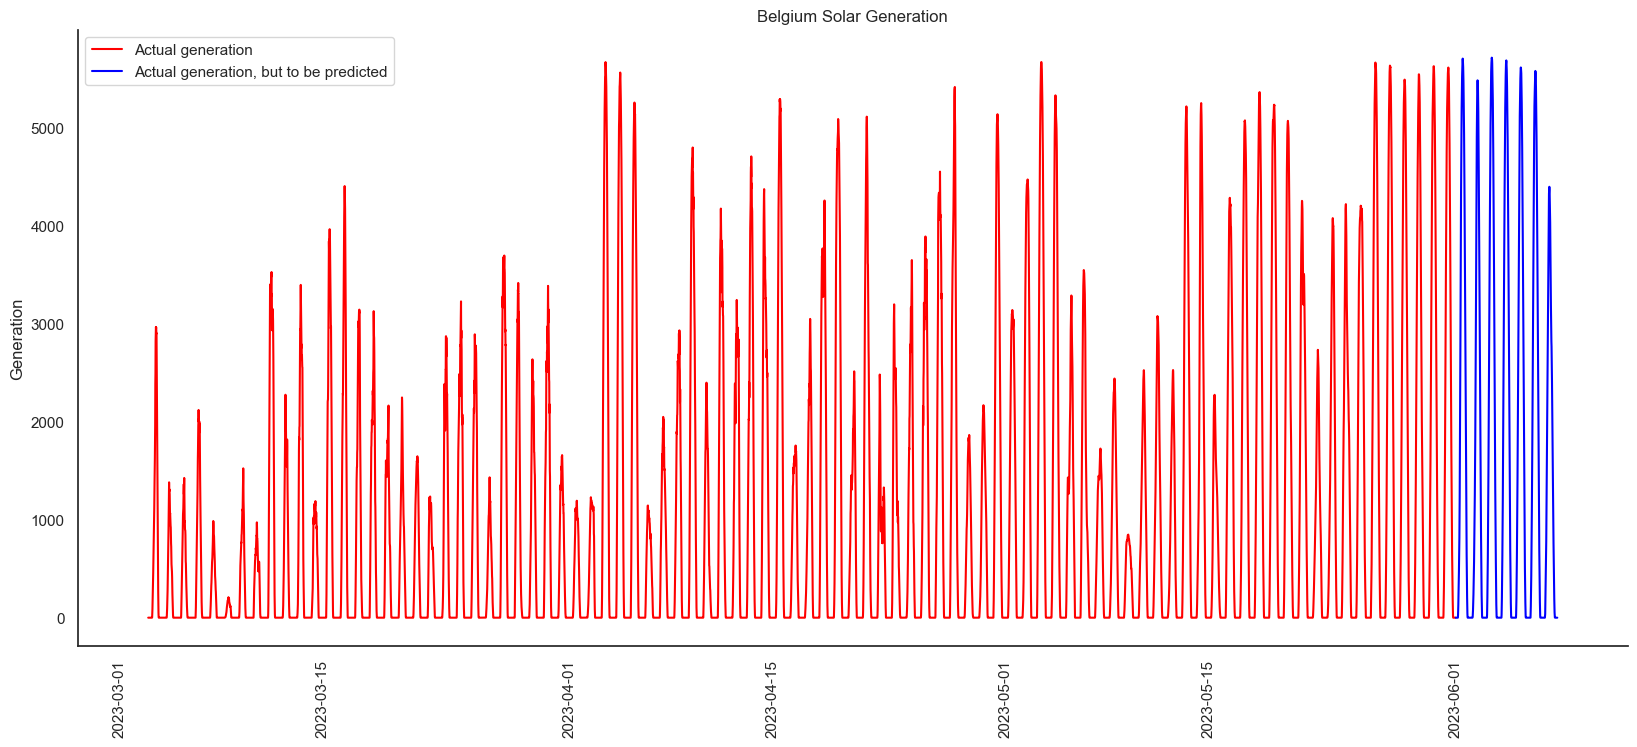

In [191]:
df_tf = df_be[['measured']].copy()
df_tf['day_of_year'] = df_tf.index.dayofyear / 365.0
df_tf['day_of_year_sin'] = np.sin(2 * np.pi * df_tf.index.dayofyear / 365)
df_tf['day_of_year_cos'] = np.cos(2 * np.pi * df_tf.index.dayofyear / 365)
df_tf['hour_sin'] = np.sin(2 * np.pi * df_tf.index.hour / 24)
df_tf['hour_cos'] = np.cos(2 * np.pi * df_tf.index.hour / 24)
df_tf_prescaled = df_tf.copy()

start_date = pd.to_datetime(start).tz_localize('UTC')
end_backward = start_date - pd.Timedelta(minutes=15)
print(f'Back to {end_backward}')
start_backward = end_backward - pd.Timedelta(days=back) + pd.Timedelta(minutes=15)
end_forward = start_date + pd.Timedelta(days=pred) - pd.Timedelta(minutes=15)
print(f'Forward to {end_forward}')

df_tf_bwd = df_tf_prescaled[start_backward:end_backward]
df_tf_fwd = df_tf_prescaled[start_date:end_forward]
df_tf_all = df_tf_prescaled[start_backward:end_forward]

plt.figure(figsize=(20,8))
sns.lineplot(df_tf_bwd.measured, color='red', label='Actual generation')
sns.lineplot(df_tf_fwd.measured, color='blue', label='Actual generation, but to be predicted')
sns.despine()
plt.title('Belgium Solar Generation')
plt.xlabel('')
plt.ylabel('Generation (MW)')
# plt.xlim(pd.to_datetime('2023-05-26'), pd.to_datetime('2023-06-07'))
plt.xticks(rotation=90)
plt.show()

def plot_losses(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [180]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_tf_bwd.measured = scaler.fit_transform(df_tf_bwd[['measured']])

seq_len = 96
num_features = len(df_tf_bwd.columns)

X, y = [], []
for i in range(seq_len, len(df_tf_bwd)):
    X.append(df_tf_bwd.iloc[i-seq_len:i].values)
    y.append(df_tf_bwd.iloc[i]['measured'])

X, y = np.array(X), np.array(y)

C:\Users\jgibb\AppData\Local\Temp\ipykernel_28400\2734455725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf_bwd.measured = scaler.fit_transform(df_tf_bwd[['measured']])


### Define models

In [192]:
model1 = Sequential([
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model2 = Sequential([
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model3 = Sequential([
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(1)
])

model4 = Sequential([
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model5 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, num_features)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model6 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, num_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model7 = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(seq_len, num_features)),
    Dropout(0.2),
    Bidirectional(LSTM(50, kernel_regularizer=l2(0.01))),
    Dropout(0.2),
    Dense(1)
])

models = {1:model1, 2:model2, 3:model3, 4:model4, 5:model5, 6:model6, 7:model7}
# models = {1:model1}

#### Find best model

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)
# scores = []

# for model_num, model in models.items():
#     print(f'Fitting model {model_num}')
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
#     history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
#     scores.append({
#         'model': model_num,
#         'loss': history.history['loss'][-1], 
#         'val_loss': history.history['val_loss'][-1],
#         'delta': abs(history.history['loss'][-1] - history.history['val_loss'][-1])
#     })

# scores_df = pd.DataFrame(scores).sort_values('loss')
# display(scores_df)

# best_model_num = int(scores_df.iloc[0]['model'])
# best_model = models[best_model_num]
# best_model.save(f'{tf_file_title}_model{best_model_num}.h5')

In [83]:
# best_model = load_model('best_model.h5')

### Predict

In [ ]:
last_sequence = df_tf_bwd[-seq_len:].values
last_sequence = last_sequence.reshape((1, seq_len, last_sequence.shape[1]))

days_to_predict = pred
samples_per_day = 96
values_to_predict = days_to_predict * samples_per_day

predicted_values = []
for i in tqdm(range(days_to_predict * samples_per_day), desc="Predicting values"):
    predicted_value = best_model.predict(last_sequence, verbose=0)
    predicted_values.append(predicted_value[0, 0])
    
    next_day_of_year = ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).dayofyear / 365.0)
    next_hour_sin = np.sin(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_hour_cos = np.cos(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_day_of_year_sin = np.sin(2 * np.pi * next_day_of_year)
    next_day_of_year_cos = np.cos(2 * np.pi * next_day_of_year)
    new_sequence_step = np.array([[predicted_value[0, 0], next_day_of_year, next_hour_sin, next_hour_cos, next_day_of_year_sin, next_day_of_year_cos]])

    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step.reshape(1, 1, new_sequence_step.shape[1]), axis=1)

predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

predicted_values_bak = predicted_values.copy()

In [85]:
predicted_values = predicted_values_bak.copy()

### Analysis

MSE	607.6624702208312
MSE	708666.1754976356
R^2	-0.3433476132412856


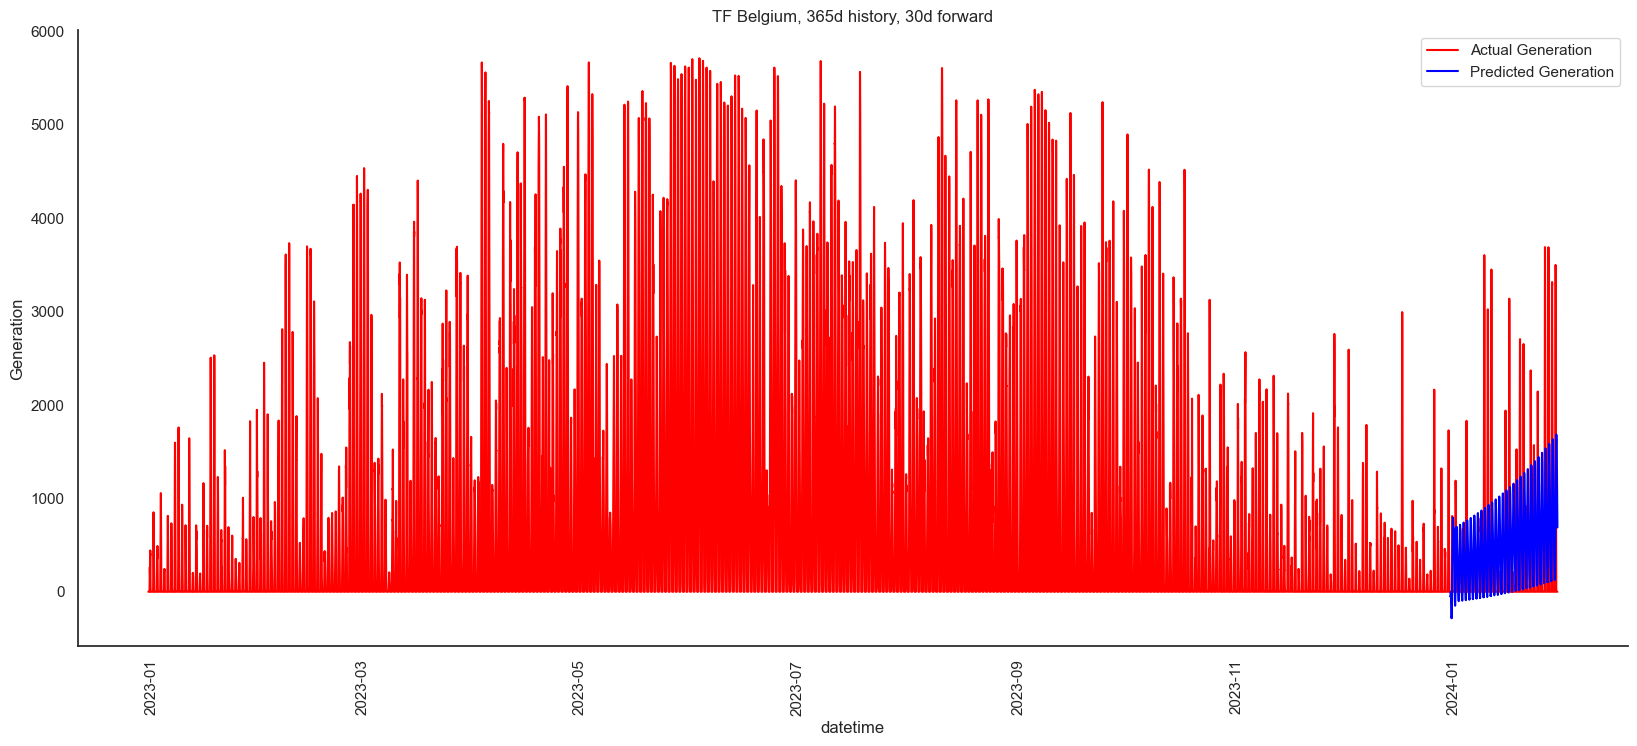

In [86]:
print(f'MSE\t{mean_absolute_error(df_tf_fwd.measured,predicted_values)}')
print(f'MSE\t{mean_squared_error(df_tf_fwd.measured,predicted_values)}')
print(f'R^2\t{r2_score(df_tf_fwd.measured,predicted_values)}')

plt.figure(figsize=(20,8))

sns.lineplot(data=df_tf_all.measured, label='Actual Generation', color='red')

# predicted_values = np.maximum(predicted_values, 0)

shift_amount = 0
crop_amount = 0
scale = 1

predicted_index = pd.date_range(start=df_tf_bwd.index[-1] + pd.Timedelta(minutes=15) + pd.Timedelta(hours=shift_amount), periods=len(predicted_values), freq='15min')
predicted_values_cropped = scale*predicted_values[crop_amount:]
predicted_index_cropped = predicted_index[crop_amount:]

sns.lineplot(x=predicted_index_cropped, y=predicted_values_cropped.flatten(), label='Predicted Generation', color='blue')
# plt.xlim(pd.to_datetime('2019-01-01'), pd.to_datetime('2025-01-01'))
sns.despine()
plt.ylabel('Generation (MW)')
plt.xticks(rotation=90)
plt.title(tf_plot_title)
plt.savefig(tf_file_title, bbox_inches='tight', transparent=True)
plt.show()

### Predict and analyse multiple models

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)

for model_num, model in models.items():
    print(f'Fitting model {model_num}')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    last_sequence = df_tf_bwd[-seq_len:].values
    last_sequence = last_sequence.reshape((1, seq_len, last_sequence.shape[1]))
    days_to_predict = pred
    samples_per_day = 96
    values_to_predict = days_to_predict * samples_per_day
    predicted_values = []
    for i in tqdm(range(days_to_predict * samples_per_day), desc="Predicting values"):
        predicted_value = model.predict(last_sequence, verbose=0)
        predicted_values.append(predicted_value[0, 0])
        next_day_of_year = ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).dayofyear / 365.0)
        next_hour_sin = np.sin(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
        next_hour_cos = np.cos(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
        next_day_of_year_sin = np.sin(2 * np.pi * next_day_of_year)
        next_day_of_year_cos = np.cos(2 * np.pi * next_day_of_year)
        new_sequence_step = np.array([[predicted_value[0, 0], next_day_of_year, next_hour_sin, next_hour_cos, next_day_of_year_sin, next_day_of_year_cos]])
        last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step.reshape(1, 1, new_sequence_step.shape[1]), axis=1)
    predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
    # predicted_values_bak = predicted_values.copy()
    print(f'MSE\t{mean_absolute_error(df_tf_fwd.measured,predicted_values)}')
    print(f'MSE\t{mean_squared_error(df_tf_fwd.measured,predicted_values)}')
    print(f'R^2\t{r2_score(df_tf_fwd.measured,predicted_values)}')
    plt.figure(figsize=(20,8))
    sns.lineplot(data=df_tf_all.measured, label='Actual Generation', color='red')
    # predicted_values = np.maximum(predicted_values, 0)
    predicted_index = pd.date_range(start=df_tf_bwd.index[-1] + pd.Timedelta(minutes=15), periods=len(predicted_values), freq='15min')
    sns.lineplot(x=predicted_index, y=predicted_values.flatten(), label='Predicted Generation', color='blue')
    sns.despine()
    plt.ylabel('Generation (MW)')
    plt.xticks(rotation=90)
    tf_plot_title = f'TF Belgium, three months history, one week forward, model {model_num}'
    plt.title(tf_plot_title)
    tf_file_title = f'tf_belgium_20230601_90d_7d_model{model_num}'
    plt.savefig(tf_file_title, bbox_inches='tight', transparent=True)
    plt.show()


# Combinations

## Import models

In [ ]:
combo_year = 2023
days_to_predict=3

In [71]:
date_array = pd.date_range(start=f'{combo_year}-01-01', end=f'{combo_year}-12-31', freq='D').strftime('%Y-%m-%d').tolist()
models = []
for date in date_array:
    models.append(pickle.load(open(f'slide/models/belgium_{date}_7d_7d_arima_sm2sa2.pkl','rb')))
len(models)

365

## Predictions

In [72]:
import_sa=2
n_per = int((96/4/import_sa)*days_to_predict)
preds = []
for i in tqdm(range(len(models)), desc="Predicting values"):
    for model in models:
        preds.append(model.predict(n_periods=n_per))
print(len(preds))

Predicting values:   0%|          | 0/365 [00:00<?, ?it/s]

Predicting values: 100%|██████████| 365/365 [19:19<00:00,  3.18s/it]

133225


In [73]:
# preds_2022_7d_3d = preds.copy()
# preds_2023_7d_3d = preds.copy()
# preds_2023_7d_7d = preds.copy()
# preds_2022_7d_7d = preds.copy()

# preds = preds_2023_7d_7d.copy()

try:
    with open(f'preds-{combo_year}-7d-{days_to_predict}d.pkl', 'wb') as f:
        pickle.dump(preds, f)
except OSError as e:
    print("Error:", e)
# with open('preds.pkl', 'rb') as f:
#     preds = pickle.load(f)

In [75]:
chunk_size = n_per
chunked_df = []
for i in tqdm(range(0, len(preds), chunk_size), desc="Concatenating chunks"):
    chunk = pd.concat(preds[i:i + chunk_size], axis=1, join='outer')
    chunked_df.append(chunk)
df_preds = pd.concat(chunked_df, axis=1)

average_preds_series = df_preds.mean(axis=1) # average the values for each date
average_preds_df = average_preds_series.to_frame(name='prediction') # convert to dataframe

Concatenating chunks: 100%|██████████| 3701/3701 [01:52<00:00, 32.93it/s]


## Compare with actual

In [77]:
average_actuals = df_be_arima[average_df.iloc[0].name.strftime('%Y-%m-%d'):average_df.iloc[-1].name.strftime('%Y-%m-%d')].copy()
average_actuals = average_series_actuals.resample('2h').mean()

In [80]:
plt.figure(figsize=(20,8))
sns.lineplot(average_actuals.measured, color = 'black', label='Actual')
sns.lineplot(average_actuals.forecast_week, color='grey', alpha=0.5, label='Their week-ahead forecast')
sns.lineplot(average_preds_df.prediction, color = 'red', label='My forecast')
sns.despine()
plt.xlabel('')
plt.ylabel('Generation (MW)')
plt.legend()
plt.title(f'Belgium {combo_year} combined prediction (ARIMA, sm2 sa2, 7d→{days_to_predict}d)')
plt.savefig(f'belgium-{combo_year}-combined-prediction-arima-sm2sa2-7d-{days_to_predict}d', bbox_inches='tight', transparent=True)
plt.show()

print(pred_vs_actual_stats(average_preds_df, average_series_actuals[0]))

Mean		817.96
Median		335.07
Mode		20.41
Std Dev		1079.01
Mean Error	-0.54
Median Error	-64.9
Mode Error	-198.17
Error Std Dev	679.08
Max Error	4141.59
MAE		397.96
MSE		461048.13
RMSE		679.01
MA%E		430551.56
R²		0.73
None
